# Information on How These Data Are Organized:

`TypeOfResponse` refers to whether participants pressed a button ("SCResp") or did not press a button ("SCRespITI") within the given time frame.

`Version` refers to the task version - these are counterbalanced across the 2 conditions (feedback (7-12)/no feedback(1-6)). We also counterbalanced for block order: version 3 & 9: MIC-MIC-MC-MC; version 4 & 10: MC-MC-MIC-MIC. Pilot analyses suggested that this order of "extending" the block length (back-to-back context) helped participants learn better, so we did not run all possible block orders (e.g., versions 1-2, 5-6, 7-8, 11-12). Unlike in the ISPC, image assignment to the PC manipulation was randomized across participants.

`LogCounter` gets added to whenever the JS records a new datapoint.

`TrialCounter` gets added to whenever a new trial has started. This is reset at the start of each block.

`MatrixCounter` gets added to throughout the task and is never reset. It is what I use to call Stimuli #s.

`RunCounter` refers to the run. The first run was a practice run of 120 images (20/key) without the distractor word printed on any, just so participants were acclimated to the S-R mappings. Afterwards, each run was its own mostly congruent or incongruent block, consistent with Bugg et al. (2011). This meant that only 4/6 items were presented in each run.

`TrialType` refers to whether the trial was a congruent (1) or incongruent trial (0).

`ContextType` refers to whether the block/run is a mostly incongruent (1) or mostly congruent (0) context.

`ItemType` refers to whether the image is PC-85 (1), PC-15 (2), or PC-50 (3).

`ImagePresented` refers to the image on each trial; `WordPresented` is the word on each trial.

`StroopNum` just refers to the combinations present. In this experiment we controlled for contingency learning by having each image have only one incongruent and congruent stimulus. So, there are only 12 pairings (3 item types, 2 images per item type, 2 trial types).

`PressCorrect` refers to the button that participants should press on that trial. This is how I define accuracy (i.e., correct: when PressCorrect = actualkeyPressed).

`ActualKeyPressed` is what key subjects pressed.

`Accuracy` & `RT` self-explanatory.

`FeedbackType` refers to whether they got correct as fb (1), incorrect as fb (2), or the fb time-out (3). In the No Feedback condition, they only get the feedback time-out.

`runStart` refers to the initiation of the countdown to begin the block; `ITI/FBOnset` refers to when the ITI or feedback was triggered; `StimTime` refers to when the image was presented;  `RespOnset` refers to when a response was made.

`AccCount` is how I give subjects accurate fb of their performance at the end of each run (i.e., a counter that gets added to after each correct trial & is divided by trial #).

`Subject` self-explanatory.

`StimRep` looks for direct stimulus repetitions (StroopNum).

---

### Here we'll just import Python specific packages and read in our data.

In [295]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as plb
import math
from scipy import stats

%matplotlib notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [296]:
%cd C:\Users\cb383\Desktop\YearThree\controllearning\fbproject\LWPCfb_rep\data
dat = pd.read_csv('AllSubsSC.csv')
#setting path for where I can a) find data and b) write csv files if I want to look more closely at the data
csvpath='C:\\Users\\cb383\\Desktop\\YearThree\\controllearning\\fbproject\\LWPCfb_rep\\data\\csvdata\\'

C:\Users\cb383\Desktop\YearThree\controllearning\fbproject\LWPCfb_rep\data


# Do Some Basic Cleaning

#### We are filtering and preparing the data for analysis.

FOR REACTION TIMES:

-Select only `TypeOfResponse` equal to `Resp` (`ITI Resp` is when subs didn't respond).

-Only take the RTs that are greater than 200ms and less than 1000 ms (filtering out too fast responses; it's overkill, probably, to have the <1000 ms filter, because those trials should be marked as ITI Resp, but just in case).

-Only take the RTs on accurate trials.

-Only take trials where the stimulus didn't repeat.


FOR ACCURACY:

-All errors are errors

In [297]:
cdat = dat.query('(TypeOfResponse != "SCRespITI") & (RT > 200) & (RT < 1000) & (Accuracy != 0) & (StimRep != 1)').copy()
adat = dat.copy()

#### Now I'm making columns in the data based off my variables so that analysis will be easier and understandable by other folks.

In [298]:
dataframes = [cdat, adat];

for df in dataframes:
    #create new boolean column & then relabel it with conditions
    df['Feedback'] = df['Version'].isin([3,4,9,10])
    df.loc[df['Version'].isin([9,10]), 'Feedback'] = 'Feedback'
    df.loc[df['Version'].isin([3,4]), 'Feedback'] = 'NoFeedback'
    
    df['BlockOrder'] = df['Version'].isin([3,4,9,10])
    df.loc[df['Version'].isin([3,9]), 'BlockOrder'] = 'IncongFirst'
    df.loc[df['Version'].isin([4,10]), 'BlockOrder'] = 'CongFirst'
    
    df['Task'] = df['RunCounter'].isin([4])
    df.loc[df['RunCounter'].isin([0]), 'Task'] = 'Practice'
    df.loc[df['RunCounter'].isin([1,2,3,4]), 'Task'] = 'Main'
    
    df['BlockType'] = df['ContextType'].isin([0])
    df.loc[df['ContextType'].isin([1]), 'BlockType'] = 'PC-28'
    df.loc[df['ContextType'].isin([0]), 'BlockType'] = 'PC-72'

    df['Congruency'] = df['TrialType'].isin([1])
    df.loc[df['TrialType'].isin([0]),'Congruency'] = 'Incongruent'
    df.loc[df['TrialType'].isin([1]),'Congruency'] = 'Congruent'
    
    df['Item'] = df['ItemType'].isin([1])
    df.loc[df['ItemType'].isin([1]),'Item'] = 'PC-85'
    df.loc[df['ItemType'].isin([2]),'Item'] = 'PC-15'
    df.loc[df['ItemType'].isin([3]),'Item'] = 'PC-50'
    
    df['ContextCong'] = df['BlockType'].isin(['High']) & df['TrialType'].isin([1])
    df.loc[(df['BlockType'].isin(['PC-28']) & df['TrialType'].isin([0])), 'ContextCong'] = 'HighIC'
    df.loc[(df['BlockType'].isin(['PC-72']) & df['TrialType'].isin([0])), 'ContextCong'] = 'LowIC'
    df.loc[(df['BlockType'].isin(['PC-28']) & df['TrialType'].isin([1])), 'ContextCong'] = 'HighC'
    df.loc[(df['BlockType'].isin(['PC-72']) & df['TrialType'].isin([1])), 'ContextCong'] = 'LowC'

# Look at Mean Cueing Effects

### In this list-wide proportion congruent paradigm, we would expect to find a congruency by proportion congruent interaction such that there is a reduced congruency difference for "low" proportion congruent blocks vs. "high" proportion congruent blocks. The basic idea is that participants learn to adjust their attentional priorities for the context they are currently in, and they need to recruit more attentional focus in the low PC condition.

### However, some LWPC paradigms cannot distinguish between list-wide and item-specific contributions to these control adjustments. To do so, you must have biased item-specific images/items (e.g., PC-85/15) and unbiased items (PC-50). Then, you manipulate the proportions of the biased items to create an overall list-level proportion (e.g., PC-75/25) - the biased items are then biased at the list and item level, whereas the unbiased items are only biased at the list level. This is the design we adopted.

### Here we are looking to replicate a picture-word biased LWPC/ISPC effect (like our ISPC expt) and an unbiased LWPC effect, and we are also investigating the effects of performance feedback on the LWPC effect. Because participants can figure out the context in which they are in (e.g., higher proportion of "hard"/incongruent trials), the LWPC is thought to reflect proactive control or control that is recruited in anticipation of temporal demand. Proactive control is thought to be "costly" to recruit. It has thus been hypothesized that proactive control is particularly sensitive to reward (like performance feedback); our previous ISPC study suggested that feedback did not impact the ISPC (thought to reflect reactive control), so we're now testing whether proactive control, via the LWPC, is affected by performance feedback. You'd expect that if the LWPC truly reflects proactive control, and proactive control is costly, we'd see that the Feedback Group shows an unbiased LWPC effect ("rewarded" to recruit proactive control), while the No Feedback Group does not ("costly" to recruit proactive control).

In [299]:
def mean_cueing_effect(df, dv, Filter1, Filter2, Filter3, Context):
    if Context == 1:
        sub_means = df.loc[df['Task']==Filter1].loc[df['Item']==Filter2].loc[df['Feedback']==Filter3].groupby(['subject','ContextCong'])[dv].mean()
    elif Context == 2:
        sub_means = df.loc[df['Task']==Filter1].loc[df['Item']!=Filter2].loc[df['Feedback']==Filter3].groupby(['subject','ContextCong'])[dv].mean()
    elif Context == 3:
        sub_means = df.loc[df['Task']==Filter1].loc[df['Item']==Filter2].loc[df['Feedback']==Filter3].groupby(['subject','CSE'])[dv].mean()
    elif Context == 4:
        sub_means = df.loc[df['Task']==Filter1].loc[df['Item']!=Filter2].loc[df['Feedback']==Filter3].groupby(['subject','CSE'])[dv].mean()
    grpmean = pd.Series.mean(sub_means, level=1)
    nsubs = math.sqrt(len(sub_means))
    grpstd = pd.Series.std(sub_means, level=1)
    sem = grpstd / nsubs
    return grpmean, sem

In [300]:
mean_cueing_effect(cdat, 'RT', 'Main', 'PC-50', 'NoFeedback', 1) #PC-50/50

(ContextCong
 HighC     655.829206
 HighIC    675.208875
 LowC      646.401047
 LowIC     666.098958
 Name: RT, dtype: float64, ContextCong
 HighC     5.068519
 HighIC    5.322342
 LowC      5.136168
 LowIC     5.224821
 Name: RT, dtype: float64)

In [301]:
mean_cueing_effect(cdat, 'RT', 'Main', 'PC-50', 'Feedback', 1) #PC-50/50

(ContextCong
 HighC     665.240504
 HighIC    676.605045
 LowC      655.296317
 LowIC     677.016188
 Name: RT, dtype: float64, ContextCong
 HighC     4.066859
 HighIC    4.109503
 LowC      4.207454
 LowIC     4.012024
 Name: RT, dtype: float64)

What about the biased items?

In [302]:
mean_cueing_effect(cdat, 'RT', 'Main', 'PC-50', 'NoFeedback', 2) #PC-85/15

(ContextCong
 HighC     609.699275
 HighIC    622.649863
 LowC      604.292661
 LowIC     632.190492
 Name: RT, dtype: float64, ContextCong
 HighC     5.539396
 HighIC    5.187497
 LowC      5.240276
 LowIC     5.399918
 Name: RT, dtype: float64)

In [303]:
mean_cueing_effect(cdat, 'RT', 'Main', 'PC-50', 'Feedback', 2) #PC-85/15

(ContextCong
 HighC     625.449307
 HighIC    628.261779
 LowC      620.206498
 LowIC     641.904210
 Name: RT, dtype: float64, ContextCong
 HighC     4.660393
 HighIC    4.144453
 LowC      4.171380
 LowIC     4.449714
 Name: RT, dtype: float64)

#### Now, what of Accuracy?

In [304]:
mean_cueing_effect(adat, 'Accuracy', 'Main', 'PC-50', 'NoFeedback', 1) #PC-50/50

(ContextCong
 HighC     0.887917
 HighIC    0.862917
 LowC      0.906667
 LowIC     0.889167
 Name: Accuracy, dtype: float64, ContextCong
 HighC     0.007466
 HighIC    0.009107
 LowC      0.006583
 LowIC     0.007652
 Name: Accuracy, dtype: float64)

In [305]:
mean_cueing_effect(adat, 'Accuracy', 'Main', 'PC-50', 'Feedback', 1) #PC-50/50

(ContextCong
 HighC     0.90750
 HighIC    0.88125
 LowC      0.90125
 LowIC     0.87500
 Name: Accuracy, dtype: float64, ContextCong
 HighC     0.004948
 HighIC    0.005435
 LowC      0.006171
 LowIC     0.007143
 Name: Accuracy, dtype: float64)

Biased Items for Accuracy...

In [306]:
mean_cueing_effect(adat, 'Accuracy', 'Main', 'PC-50', 'NoFeedback', 2) #PC-85/15

(ContextCong
 HighC     0.928125
 HighIC    0.909564
 LowC      0.941951
 LowIC     0.883333
 Name: Accuracy, dtype: float64, ContextCong
 HighC     0.006117
 HighIC    0.006162
 LowC      0.003705
 LowIC     0.008068
 Name: Accuracy, dtype: float64)

In [307]:
mean_cueing_effect(adat, 'Accuracy', 'Main', 'PC-50', 'Feedback', 2) #PC-85/15

(ContextCong
 HighC     0.913021
 HighIC    0.930303
 LowC      0.943845
 LowIC     0.877604
 Name: Accuracy, dtype: float64, ContextCong
 HighC     0.004714
 HighIC    0.003952
 LowC      0.002746
 LowIC     0.007098
 Name: Accuracy, dtype: float64)

#### Let's dig a little deeper now.

## Run Repeated-Measures ANOVAs in R

In [308]:
%cd csvdata

C:\Users\cb383\Desktop\YearThree\controllearning\fbproject\LWPCfb_rep\data\csvdata


In [309]:
RTmeans = cdat.loc[cdat['Task']=='Main'].loc[cdat['Item']!='PC-50'].groupby(['subject', 'BlockType','Congruency', 'Feedback', 'BlockOrder'])['RT'].mean().reset_index();
ACCmeans = adat.loc[adat['Task']=='Main'].loc[adat['Item']!='PC-50'].groupby(['subject', 'BlockType','Congruency', 'Feedback', 'BlockOrder'])['Accuracy'].mean().reset_index();

RTmeans_PC50 = cdat.loc[cdat['Task']=='Main'].loc[cdat['Item']=='PC-50'].groupby(['subject', 'BlockType','Congruency', 'Feedback', 'BlockOrder'])['RT'].mean().reset_index();
ACCmeans_PC50 = adat.loc[adat['Task']=='Main'].loc[adat['Item']=='PC-50'].groupby(['subject', 'BlockType','Congruency', 'Feedback', 'BlockOrder'])['Accuracy'].mean().reset_index();

RTmeans.to_csv(csvpath+'SC_ANOVA_RT.csv')
ACCmeans.to_csv(csvpath+'SC_ANOVA_ACC.csv')

RTmeans_PC50.to_csv(csvpath+'SCT_ANOVA_RT.csv')
ACCmeans_PC50.to_csv(csvpath+'SCT_ANOVA_ACC.csv')

In [310]:
%%writefile SCAnova.R

install.packages("psych",repos='https://mirrors.nics.utk.edu/cran/')
install.packages("ez",repos='https://mirrors.nics.utk.edu/cran/')
library(psych)
library(ez)

rawRTData <- read.csv('SC_ANOVA_RT.csv')

rawRTData$subject = as.factor(rawRTData$subject)
rawRTData$BlockType = as.factor(rawRTData$BlockType)
rawRTData$Congruency = as.factor(rawRTData$Congruency)
rawRTData$Feedback = as.factor(rawRTData$Feedback)
rawRTData$BlockOrder = as.factor(rawRTData$BlockOrder)

SC_RT_runANOVA <- ezANOVA(data=as.data.frame(rawRTData),
                                  dv=.(RT),
                                  wid=.(subject),
                                  within=.(BlockType, Congruency),
                                  between=.(Feedback, BlockOrder),
                                  detailed=TRUE)
print(SC_RT_runANOVA)

#

rawRTData_T <- read.csv('SCT_ANOVA_RT.csv')

rawRTData_T$subject = as.factor(rawRTData_T$subject)
rawRTData_T$BlockType = as.factor(rawRTData_T$BlockType)
rawRTData_T$Congruency = as.factor(rawRTData_T$Congruency)
rawRTData_T$Feedback = as.factor(rawRTData_T$Feedback)
rawRTData_T$BlockOrder = as.factor(rawRTData_T$BlockOrder)

SCT_RT_runANOVA <- ezANOVA(data=as.data.frame(rawRTData_T),
                                  dv=.(RT),
                                  wid=.(subject),
                                  within=.(BlockType, Congruency),
                                  between=.(Feedback, BlockOrder),
                                  detailed=TRUE)
print(SCT_RT_runANOVA)

#

rawACCData <- read.csv('SC_ANOVA_ACC.csv')

rawACCData$subject = as.factor(rawACCData$subject)
rawACCData$BlockType = as.factor(rawACCData$BlockType)
rawACCData$Congruency = as.factor(rawACCData$Congruency)
rawACCData$Feedback = as.factor(rawACCData$Feedback)
rawACCData$BlockOrder = as.factor(rawACCData$BlockOrder)

SC_ACC_runANOVA <- ezANOVA(data=as.data.frame(rawACCData),
                                  dv=.(Accuracy),
                                  wid=.(subject),
                                  within=.(BlockType, Congruency),
                                  between=.(Feedback, BlockOrder),
                                  detailed=TRUE)
print(SC_ACC_runANOVA)

#

rawACCData_T <- read.csv('SCT_ANOVA_ACC.csv')

rawACCData_T$subject = as.factor(rawACCData_T$subject)
rawACCData_T$BlockType = as.factor(rawACCData_T$BlockType)
rawACCData_T$Congruency = as.factor(rawACCData_T$Congruency)
rawACCData_T$Feedback = as.factor(rawACCData_T$Feedback)
rawACCData_T$BlockOrder = as.factor(rawACCData_T$BlockOrder)

SCT_ACC_runANOVA <- ezANOVA(data=as.data.frame(rawACCData_T),
                                  dv=.(Accuracy),
                                  wid=.(subject),
                                  within=.(BlockType, Congruency),
                                  between=.(Feedback, BlockOrder),
                                  detailed=TRUE)
print(SCT_ACC_runANOVA)

Overwriting SCAnova.R


In [311]:
! Rscript SCAnova.R

package 'psych' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cb383\AppData\Local\Temp\RtmpQB7vpc\downloaded_packages
package 'ez' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cb383\AppData\Local\Temp\RtmpQB7vpc\downloaded_packages
$ANOVA
                                     Effect DFn DFd          SSn        SSd
1                               (Intercept)   1 116 1.863508e+08 2376239.49
2                                  Feedback   1 116 1.656010e+04 2376239.49
3                                BlockOrder   1 116 4.072254e+04 2376239.49
5                                 BlockType   1 116 1.178190e+03  121795.64
9                                Congruency   1 116 3.203810e+04   54378.26
4                       Feedback:BlockOrder   1 116 1.310091e+04 2376239.49
6                        Feedback:BlockType   1 116 1.364656e+02  121795.64
7                      BlockOrder:BlockType   1 116 3.302474

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/psych_1.8.12.zip'
Content type 'application/zip' length 5908111 bytes (5.6 MB)
downloaded 5.6 MB

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/ez_4.4-0.zip'
Content type 'application/zip' length 332373 bytes (324 KB)
downloaded 324 KB

Warning message:
package 'psych' was built under R version 3.4.4 
Warning message:
package 'ez' was built under R version 3.4.4 


We observe a context x congruency effect for the biased item/lwpc items for RT and accuracy, but which was modulated by block order for accuracy. 

Forr the unbiased items, we observe a significant LWPC effect modulated by feedback group. For accuracy, the LWPC effect was modulated by block order but not feedback group. What does this look like graphically? And is this like the ISPC effect, where there was a big RT/ACC trade-off?

# Look at the Results Graphically

In [312]:
figurepath='C:\\Users\\cb383\\Desktop\\YearThree\\controllearning\\fbproject\\LWPCfb_rep\\data\\figures\\'
sns.set(context='notebook', style='ticks', font='Myriad Pro', font_scale=2.5, color_codes=False, rc=None);

In [313]:
def mybargraph(x,y,hue,col,order,data,xlabel,ylabel,title,legendtitle,ymin,ymax,figname,stepsize):
    g = sns.catplot(x=x, 
                       y=y, 
                       hue=hue,
                       col=col,
                       order=order,
                       data=data,
                       palette=("Set2"),
                       ci=68, 
                       kind="bar",
                       height=10, 
                       aspect=.7,
                       saturation=0.6,
                       legend_out = True);
    g.set_axis_labels(xlabel, ylabel);
    g.despine(left=True);

    # check axes and find which have legends
    for ax in g.axes.flat:
        leg = g.axes.flat[0].get_legend()
        if not leg is None: 
            break
    
    # or legend may be on a figure
    if leg is None: 
        leg = g._legend

    leg.set_title(legendtitle);
    g.set(ylim=(ymin, ymax), yticks=np.arange(ymin,ymax+stepsize,stepsize))
    g.fig.suptitle(title, y = 1.05)
    
    titles = ["No Feedback Group", "Feedback Group"]
    for ax, title in zip(g.axes.flat, titles):
        ax.set_title(title)
        
    plb.savefig(figurepath+figname, dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


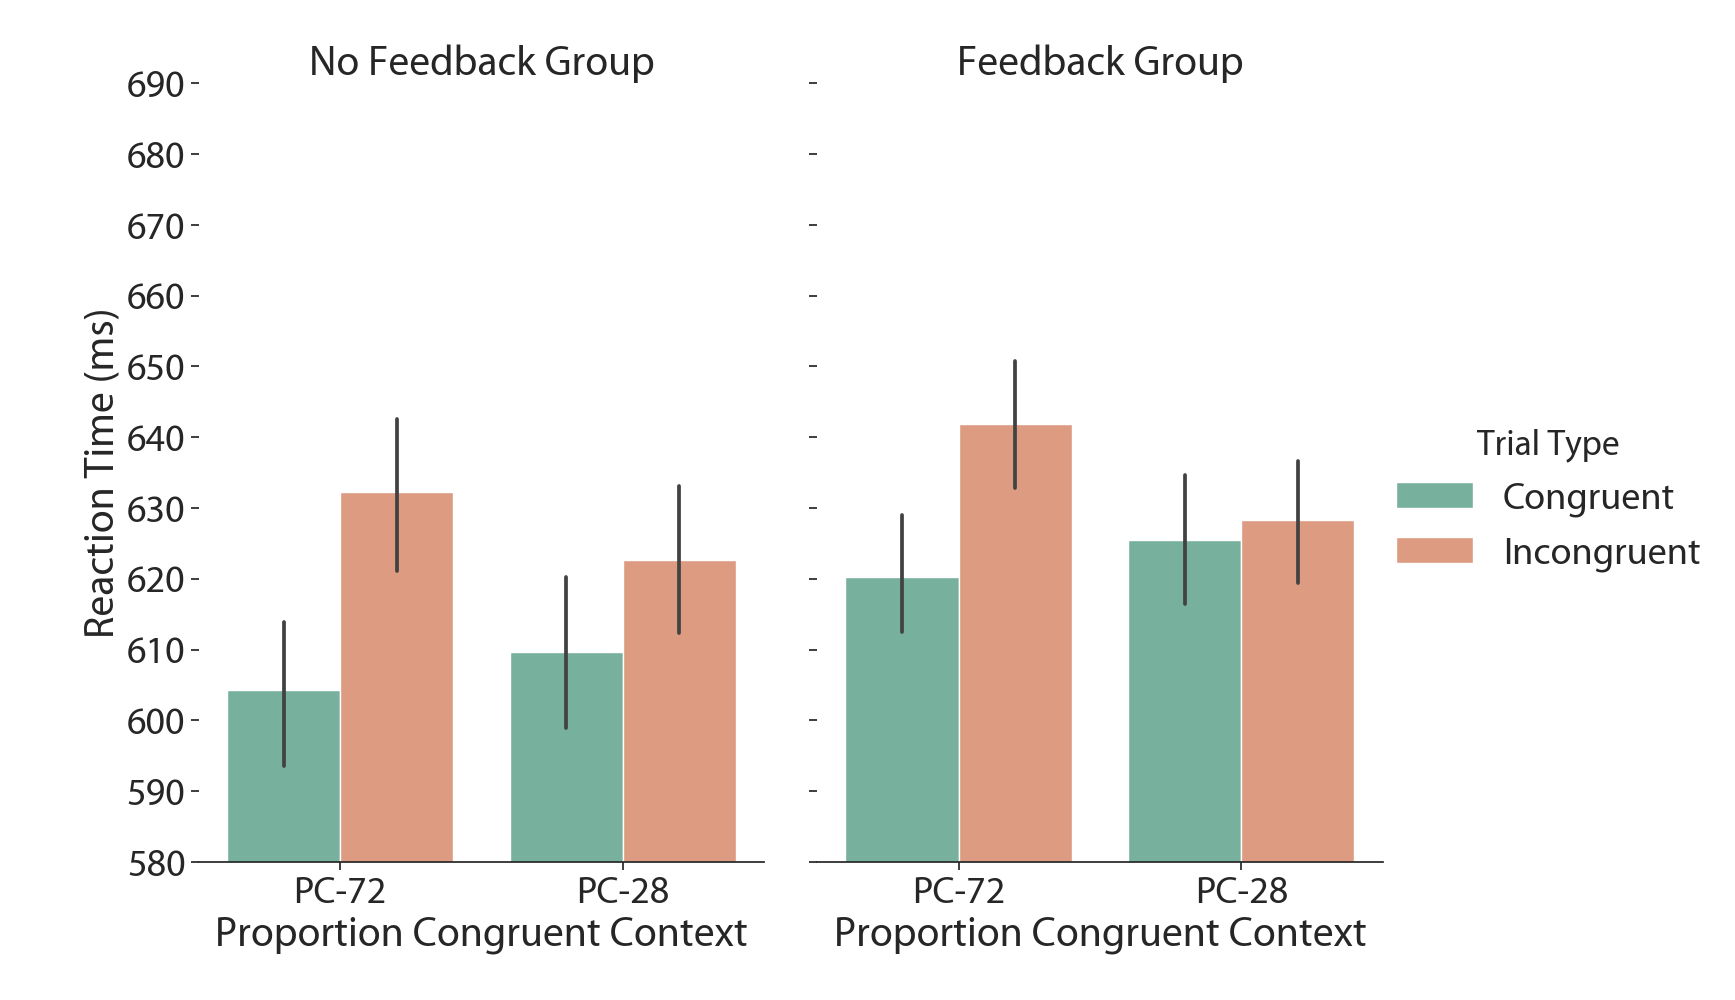

In [314]:
mybargraph("BlockType","RT","Congruency","Feedback",["PC-72", "PC-28"],RTmeans,"Proportion Congruent Context","Reaction Time (ms)","Experiment 2b Biased ISPC/LWPC Items","Trial Type",580,690,"LWPC_RT_maintask.png",10)

<IPython.core.display.Javascript object>


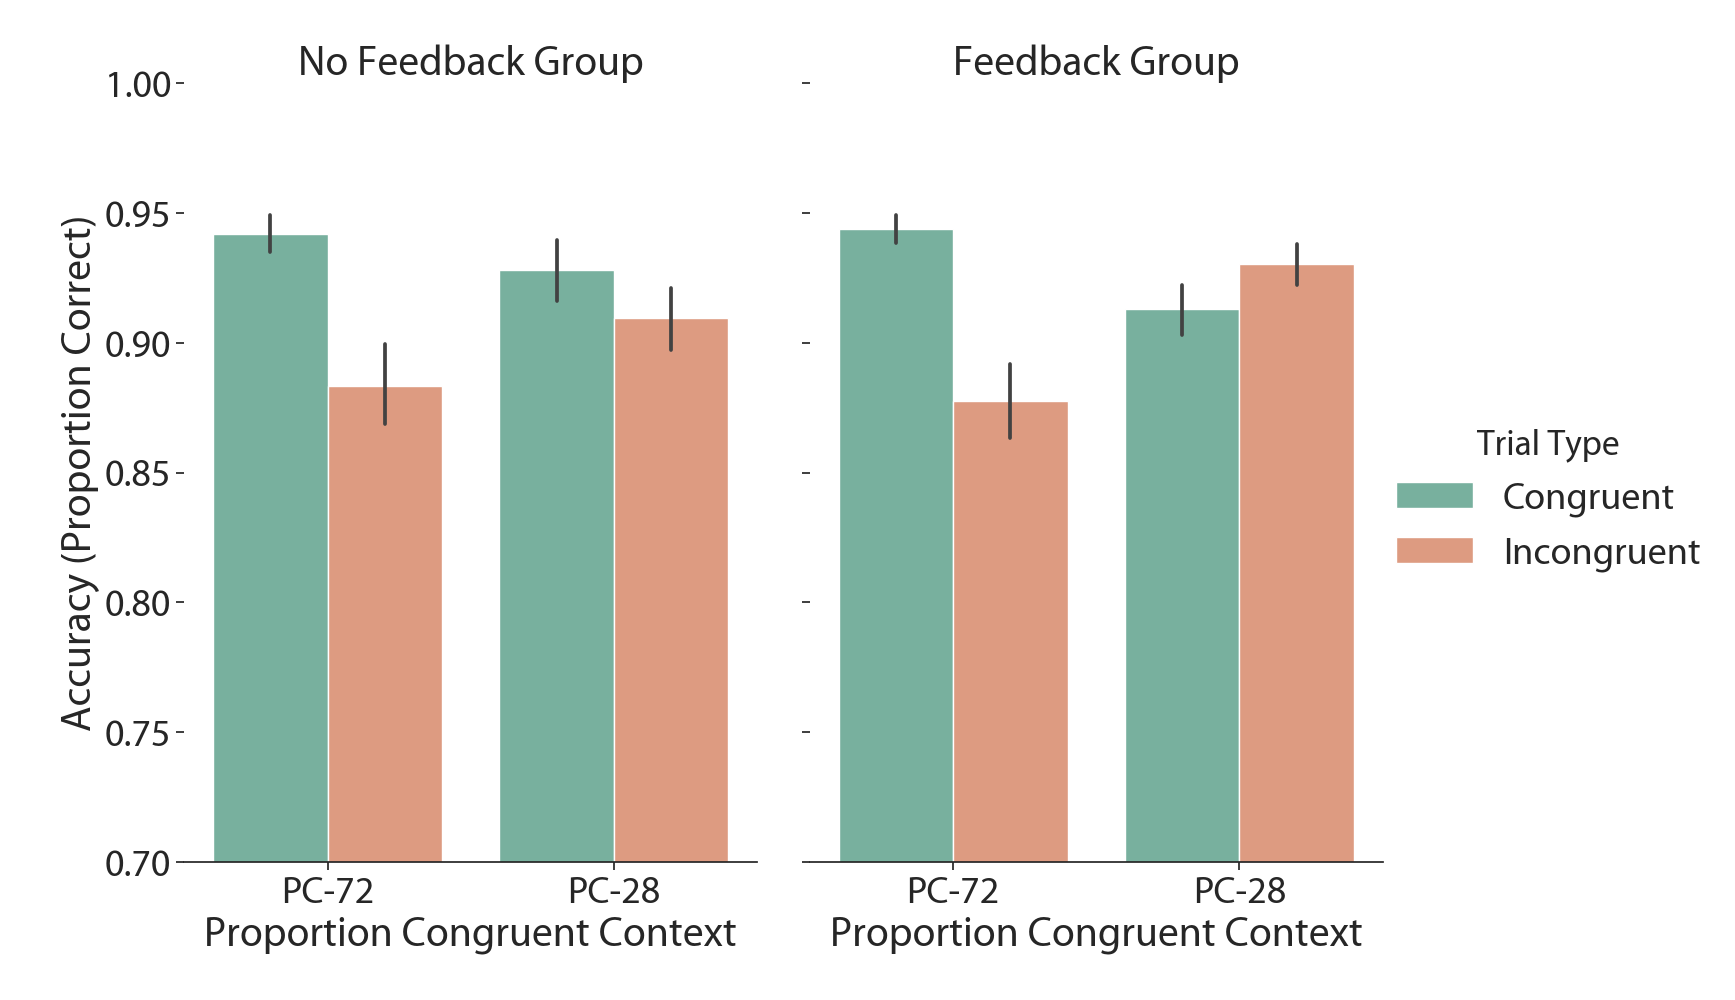

In [315]:
mybargraph("BlockType","Accuracy","Congruency","Feedback",["PC-72", "PC-28"],ACCmeans,"Proportion Congruent Context","Accuracy (Proportion Correct)","Experiment 2b Biased ISPC/LWPC Items","Trial Type",0.7,1.0,"LWPC_ACC_maintask.png",0.05)

<IPython.core.display.Javascript object>


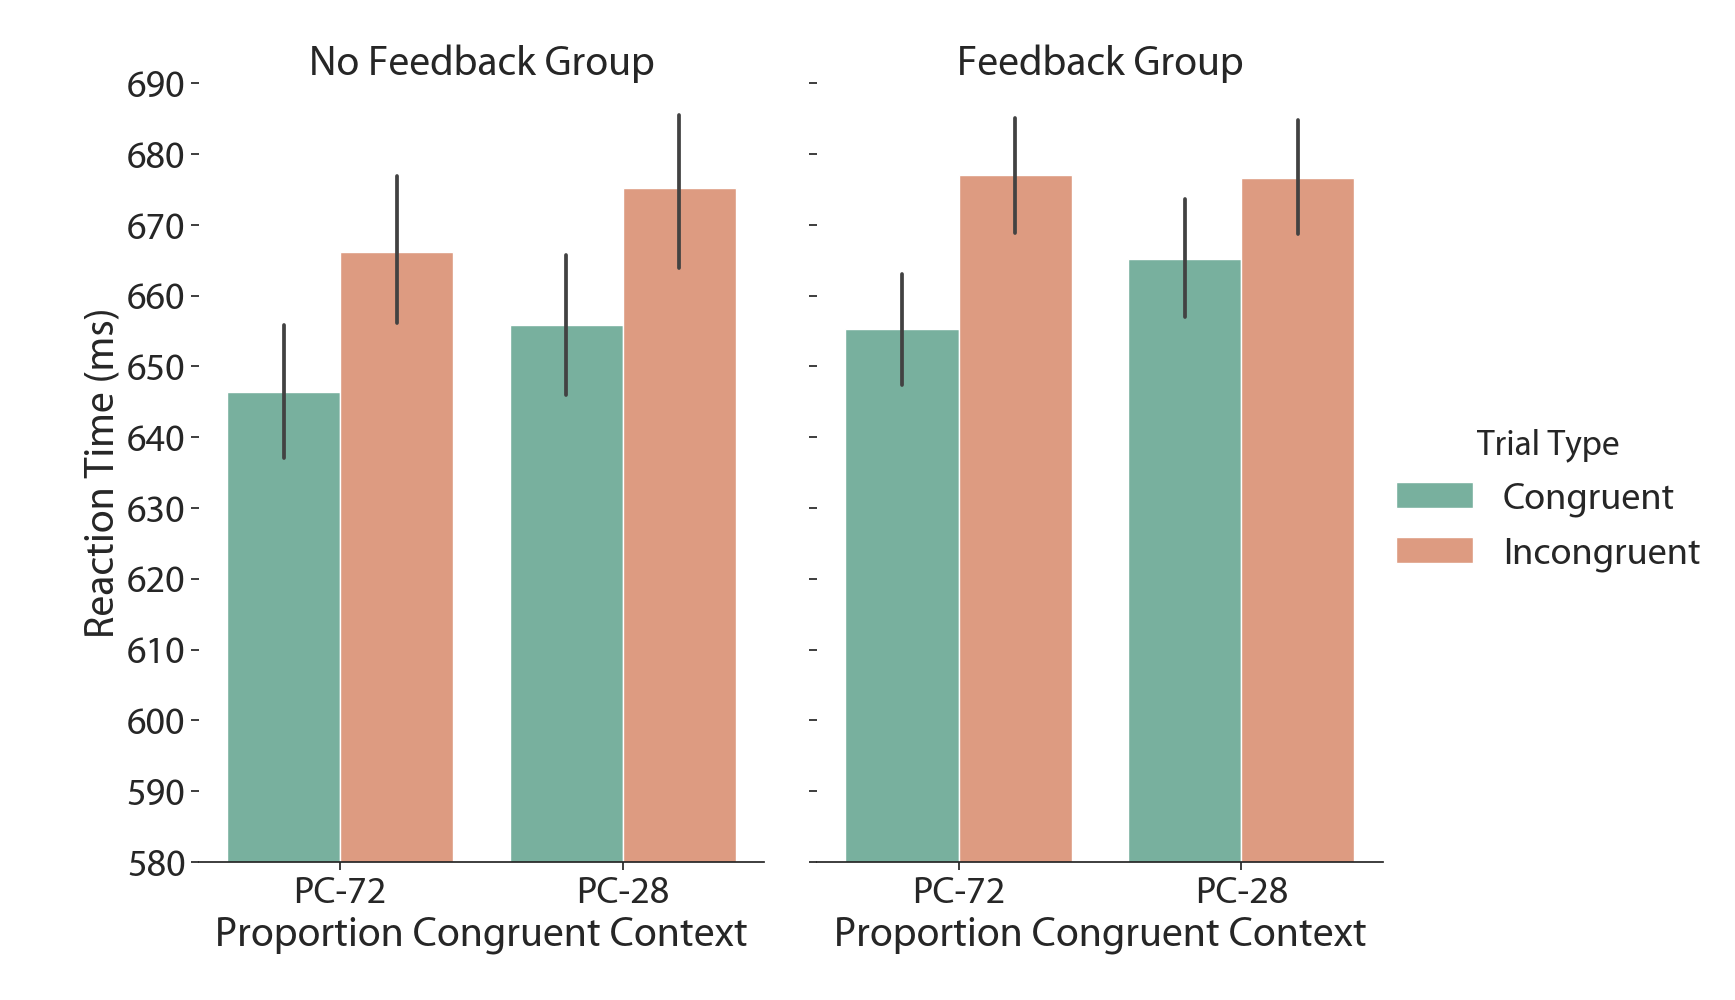

In [316]:
mybargraph("BlockType","RT","Congruency","Feedback",["PC-72", "PC-28"],RTmeans_PC50,"Proportion Congruent Context","Reaction Time (ms)","Experiment 2b Unbiased LWPC Items","Trial Type",580,690,"LWPC_RT_pc50.png",10)

<IPython.core.display.Javascript object>


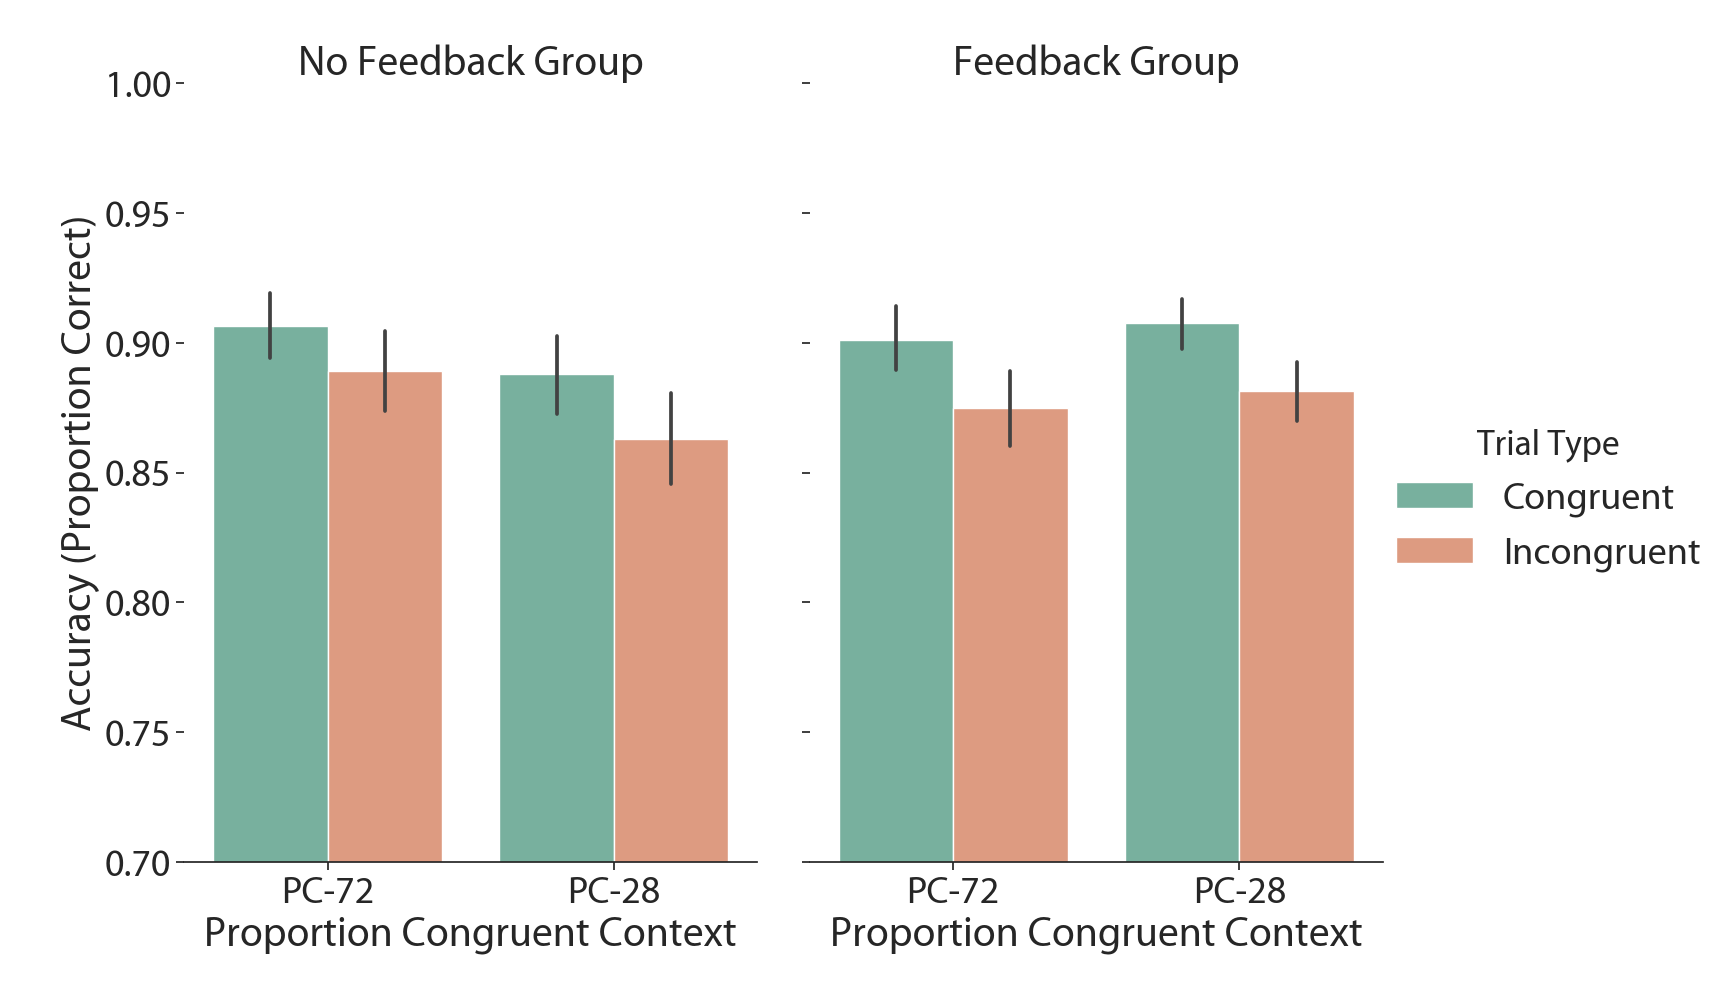

In [317]:
mybargraph("BlockType","Accuracy","Congruency","Feedback",["PC-72", "PC-28"],ACCmeans_PC50,"Proportion Congruent Context","Accuracy (Proportion Correct)","Experiment 2b Unbiased LWPC Items","Trial Type",0.7,1.0,"LWPC_ACC_pc50.png",0.05)

# Creating Variables

##### this is to calculate the interaction effects for later correlation graphs, with overall RT/acc in each condition serving as a correction
##### also used to calculate inverse efficiency scores, test RT/acc trade-off

In [318]:
FBsubslim = 120;
NoFBsubslim = 60; #subs 1-60 in the list are no fb grp, while 61-120 are fb

In [319]:
#needed to be outside the function because python wasn't recognizing the dfname as an input when dfname = pd.DataFrame()
FB_RT = pd.DataFrame();
NoFB_RT = pd.DataFrame();
FB_ACC = pd.DataFrame();
NoFB_ACC = pd.DataFrame();

In [320]:
def create_wide_df(df,dfname,dv,Group,lim1,lim2):
    lists = [[] for list in range(0,9)]
    data_filter = df[df.Task=='Main'];
    data = data_filter[data_filter.Feedback == Group]
    
    for ID in range(lim1, lim2):
        sub = data[data.subject == ID]
        lists[0].append(ID)
        submain = sub[sub.Item != 'PC-50']
        LowC_trials = submain[submain.ContextCong == 'LowC'][dv].mean()
        LowIC_trials = submain[submain.ContextCong == 'LowIC'][dv].mean()
        HighC_trials = submain[submain.ContextCong == 'HighC'][dv].mean()
        HighIC_trials = submain[submain.ContextCong == 'HighIC'][dv].mean()
        subtransfer = sub[sub.Item == 'PC-50']
        LowC_trials_T = subtransfer[subtransfer.ContextCong == 'LowC'][dv].mean()
        LowIC_trials_T = subtransfer[subtransfer.ContextCong == 'LowIC'][dv].mean()
        HighC_trials_T = subtransfer[subtransfer.ContextCong == 'HighC'][dv].mean()
        HighIC_trials_T = subtransfer[subtransfer.ContextCong == 'HighIC'][dv].mean()
        lists[1].append(LowC_trials)
        lists[2].append(LowIC_trials)
        lists[3].append(HighC_trials)
        lists[4].append(HighIC_trials)
        lists[5].append(LowC_trials_T)
        lists[6].append(LowIC_trials_T)
        lists[7].append(HighC_trials_T)
        lists[8].append(HighIC_trials_T)
        
    dfname['SubjectID'] = lists[0]
    dfname['LowC'] = lists[1]
    dfname['LowIC'] = lists[2]
    dfname['HighC'] = lists[3]
    dfname['HighIC'] = lists[4]
    dfname['LowC_T'] = lists[5]
    dfname['LowIC_T'] = lists[6]
    dfname['HighC_T'] = lists[7]
    dfname['HighIC_T'] = lists[8]

In [321]:
create_wide_df(cdat,FB_RT,'RT','Feedback',NoFBsubslim+1,FBsubslim+1);

In [322]:
create_wide_df(cdat,NoFB_RT,'RT','NoFeedback',1,NoFBsubslim+1);

In [323]:
create_wide_df(adat,FB_ACC,'Accuracy','Feedback',(NoFBsubslim+1),(FBsubslim+1));

In [324]:
create_wide_df(adat,NoFB_ACC,'Accuracy','NoFeedback',1,NoFBsubslim+1);

In [325]:
def calc_PCbycong_interaction(df, transfer, RTacc):
    if transfer == 0:
        InteractionEffect = (df.LowIC - df.LowC) - (df.HighIC - df.HighC);
    elif transfer == 1:
        InteractionEffect = (df.LowIC_T - df.LowC_T) - (df.HighIC_T - df.HighC_T);
    
    InteractionEffect = InteractionEffect.reset_index();
    
    if RTacc == 1:
        InteractionEffect.columns = ['index', 'RTs']
    elif RTacc == 0:
        InteractionEffect.columns = ['index', 'ACC']
    
    return InteractionEffect

In [326]:
SC_RT_FB = calc_PCbycong_interaction(FB_RT, 0, 1)

In [327]:
SCT_RT_FB = calc_PCbycong_interaction(FB_RT, 1, 1)

In [328]:
SC_ACC_FB = calc_PCbycong_interaction(FB_ACC, 0, 0)

In [329]:
SCT_ACC_FB = calc_PCbycong_interaction(FB_ACC, 1, 0)

In [330]:
SC_RT_NoFB = calc_PCbycong_interaction(NoFB_RT, 0, 1)

In [331]:
SCT_RT_NoFB = calc_PCbycong_interaction(NoFB_RT, 1, 1)

In [332]:
SC_ACC_NoFB = calc_PCbycong_interaction(NoFB_ACC, 0, 0)

In [333]:
SCT_ACC_NoFB = calc_PCbycong_interaction(NoFB_ACC, 1, 0)

In [334]:
#interaction effects - both groups
SC_RT = SC_RT_NoFB.append(SC_RT_FB)
SC_ACC = SC_ACC_NoFB.append(SC_ACC_FB)
SCT_RT = SCT_RT_NoFB.append(SCT_RT_FB)
SCT_ACC = SCT_ACC_NoFB.append(SCT_ACC_FB)

In [335]:
def means_overall_group(df, filternum, filter1, filter2, dv):
    if filternum == 0:
        X = df.groupby(['subject'])[dv].mean().reset_index();       
    elif filternum == 1:
        X = df.loc[df['Task'] == 'Main'].loc[df['Item'] == filter1].groupby(['subject'])[dv].mean().reset_index();
    elif filternum == 2:
        X = df.loc[df['Task'] == 'Main'].loc[df['Item'] != filter1].groupby(['subject'])[dv].mean().reset_index();
    elif filternum == 3:
        X = df.loc[df['Task'] == 'Main'].loc[df['Item'] == filter1].loc[df['Feedback'] == filter2].groupby(['subject'])[dv].mean().reset_index()
    elif filternum == 4:
        X = df.loc[df['Task'] == 'Main'].loc[df['Item'] != filter1].loc[df['Feedback'] == filter2].groupby(['subject'])[dv].mean().reset_index()

        
    X = X.drop('subject',1)
    
    return X

In [336]:
overallRT = means_overall_group(cdat, 0, 0, 0, 'RT')

In [337]:
overallACC = means_overall_group(adat, 0, 0, 0, 'Accuracy')

In [338]:
overallMainRT = means_overall_group(cdat, 2, 'PC-50', 0, 'RT') #main refers to pc-85/15 here

In [339]:
overallMainACC = means_overall_group(adat, 2, 'PC-50', 0, 'Accuracy') #main refers to pc-85/15 here

In [340]:
overallRT_T = means_overall_group(cdat, 1, 'PC-50', 0, 'RT') #_T refers to pc-50 here

In [341]:
overallACC_T = means_overall_group(adat,  1, 'PC-50', 0, 'Accuracy') #_T refers to pc-50 here

In [342]:
MainRT_FB = means_overall_group(cdat, 4, 'PC-50', 'Feedback', 'RT')

In [343]:
MainACC_FB = means_overall_group(adat, 4, 'PC-50', 'Feedback', 'Accuracy')

In [344]:
RT_FB_T = means_overall_group(cdat, 3, 'PC-50', 'Feedback', 'RT')

In [345]:
ACC_FB_T = means_overall_group(adat, 3, 'PC-50', 'Feedback', 'Accuracy')

In [346]:
MainRT_NoFB = means_overall_group(cdat, 4, 'PC-50', 'NoFeedback', 'RT')

In [347]:
MainACC_NoFB = means_overall_group(adat, 4, 'PC-50', 'NoFeedback', 'Accuracy')

In [348]:
RT_NoFB_T = means_overall_group(cdat, 3, 'PC-50', 'NoFeedback', 'RT')

In [349]:
ACC_NoFB_T = means_overall_group(adat, 3, 'PC-50', 'NoFeedback', 'Accuracy')

What about speed/accuracy trade-offs?

In [350]:
#PC-85/15 overall
stats.linregress(overallRT.RT,overallACC.Accuracy)

LinregressResult(slope=-0.0006019879708053306, intercept=1.282518839535633, rvalue=-0.5612576997512843, pvalue=2.592575520603711e-11, stderr=8.171965941258951e-05)

In [351]:
#PC-50 overall
stats.linregress(overallRT_T.RT,overallACC_T.Accuracy)

LinregressResult(slope=-0.0007279967745770403, intercept=1.3725147099643595, rvalue=-0.6053465229496201, pvalue=2.4117018407460674e-13, stderr=8.812046128474482e-05)

In [352]:
#PC-85/15 w/in no FB group
stats.linregress(MainRT_NoFB.RT,MainACC_NoFB.Accuracy)

LinregressResult(slope=-0.00043143354657258954, intercept=1.1876604052628068, rvalue=-0.5379735495421286, pvalue=9.293136107468966e-06, stderr=8.876603960499386e-05)

In [353]:
#PC-50 w/in no FB group
stats.linregress(RT_NoFB_T.RT,ACC_NoFB_T.Accuracy)

LinregressResult(slope=-0.0008758930873776713, intercept=1.4650277684153163, rvalue=-0.7101656205772586, pvalue=2.092164085290582e-10, stderr=0.00011401749451327048)

In [354]:
#PC-85/15 w/in FB group
stats.linregress(MainRT_FB.RT,MainACC_FB.Accuracy)

LinregressResult(slope=-0.0004073194663559017, intercept=1.1853597164628396, rvalue=-0.5195799243736485, pvalue=2.0984582740069257e-05, stderr=8.795107543899221e-05)

In [355]:
#PC-50 w/in FB group
stats.linregress(RT_FB_T.RT,ACC_FB_T.Accuracy)

LinregressResult(slope=-0.0004956024186489095, intercept=1.22238542446097, rvalue=-0.4293757919140742, pvalue=0.0006183526979158734, stderr=0.0001368769036711302)

# What about Inverse Efficiency, given the RT/ACC trade-off?

Inverse Efficiency is another metric that shows whether someone is more efficient at responding, not just faster (i.e., it doesn't come with a cost in accuracy). To calculate inverse efficiency, we take the mean RT in each condition and divide it by the mean Accuracy (Proportion Correct) in each condition, for each subject. This gives us an RT corrected for accuracy.

In [356]:
IE_FB = pd.DataFrame()
IE_NoFB = pd.DataFrame()
IE_all = pd.DataFrame()

IE_FB_T = pd.DataFrame()
IE_NoFB_T = pd.DataFrame()
IE_all_T = pd.DataFrame()

In [357]:
def inverse_efficiency_calc(df1, df2, Group, Transfer, dfname):
    #rt is df1 and proportion correct has to be df2
    lists = [[] for list in range(0,9)]
    
    for ID in range(0,len(df1)):
        sub = df1.SubjectID[ID]
        lists[0].append(sub)
        IE_LowC = df1.LowC[ID] / df2.LowC[ID]
        IE_LowIC = df1.LowIC[ID] / df2.LowIC[ID]
        IE_HighC = df1.HighC[ID] / df2.HighC[ID]
        IE_HighIC = df1.HighIC[ID] / df2.HighIC[ID]
        IE_LowC_T = df1.LowC_T[ID] / df2.LowC_T[ID]
        IE_LowIC_T = df1.LowIC_T[ID] / df2.LowIC_T[ID]
        IE_HighC_T = df1.HighC_T[ID] / df2.HighC_T[ID]
        IE_HighIC_T = df1.HighIC_T[ID] / df2.HighIC_T[ID]
        ISPC_Main = (IE_LowIC - IE_LowC) - (IE_HighIC - IE_HighC)
        ISPC_T = (IE_LowIC_T - IE_LowC_T) - (IE_HighIC_T - IE_HighC_T)
        avgIEtotal = (IE_LowC + IE_LowIC + IE_HighC + IE_HighIC) / 4
        avgIEtotal_T = (IE_LowC_T + IE_LowIC_T + IE_HighC_T + IE_HighIC_T) / 4
        
        if Transfer == 0:
            lists[1].append(IE_LowC)
            lists[2].append(IE_LowIC)
            lists[3].append(IE_HighC)
            lists[4].append(IE_HighIC)
            lists[5].append(ISPC_Main)
            lists[6].append(avgIEtotal)
        elif Transfer == 1:
            lists[1].append(IE_LowC_T)
            lists[2].append(IE_LowIC_T)
            lists[3].append(IE_HighC_T)
            lists[4].append(IE_HighIC_T)
            lists[5].append(ISPC_T)
            lists[6].append(avgIEtotal_T)
        
        lists[7].append(Group)
        
        if ID < 30:
            lists[8].append("IncongFirst")
        elif ID in range(30,60):
            lists[8].append("CongFirst")
        elif ID in range(60,90):
            lists[8].append("IncongFirst")
        elif ID in range(90,120):
            lists[8].append("CongFirst")
    
    dfname['SubjectID'] = lists[0]
    dfname['C1_1'] = lists[1]
    dfname['C1_2'] = lists[2]
    dfname['C2_1'] = lists[3]
    dfname['C2_2'] = lists[4]
    dfname['Effect'] = lists[5]
    dfname['OverallIE'] = lists[6]
    dfname['Feedback'] = lists[7]
    dfname['BlockOrder'] = lists[8]

In [358]:
inverse_efficiency_calc(FB_RT, FB_ACC, "Feedback", 0, IE_FB)

In [359]:
inverse_efficiency_calc(NoFB_RT, NoFB_ACC, "NoFeedback", 0, IE_NoFB)

In [360]:
inverse_efficiency_calc(FB_RT, FB_ACC, "Feedback", 1, IE_FB_T)

In [361]:
inverse_efficiency_calc(NoFB_RT, NoFB_ACC, "NoFeedback", 1, IE_NoFB_T)

In [362]:
IE_all = IE_NoFB.append(IE_FB)
IE_all_T = IE_NoFB_T.append(IE_FB_T)

In [363]:
def change_to_longform(df):
    X = pd.wide_to_long(df,['C1', 'C2'],i=["SubjectID","Effect", "OverallIE", "Feedback", "BlockOrder"],j="Congruency",sep='_',suffix='\w')
    X = X.reset_index()
    X = pd.wide_to_long(X,['C'],i=["SubjectID","Effect", "OverallIE","Feedback", "BlockOrder", "Congruency"],j="DemandCue")
    X = X.reset_index()
    X.columns = ['SubjectID', "Effect", "OverallIE",'Feedback', 'BlockOrder', 'Congruency', 'DemandCue', 'IE'];
    return X

In [364]:
IE_all = change_to_longform(IE_all)

In [365]:
IE_all_T = change_to_longform(IE_all_T)

In [366]:
#wide_to_long wasn't working if there were strings involved, so I used numbers for the levels and I'm renaming here
dflist = [IE_all, IE_all_T]

for df in dflist:
    df['TrialType'] = df['Congruency'].isin([1,2])
    df.loc[df['Congruency'].isin([1]),'TrialType'] = 'Congruent'
    df.loc[df['Congruency'].isin([2]),'TrialType'] = 'Incongruent'
    
    df['CueType'] = df['DemandCue'].isin([1,2])
    df.loc[df['DemandCue'].isin([1]),'CueType'] = 'PC-72'
    df.loc[df['DemandCue'].isin([2]),'CueType'] = 'PC-28'

In [367]:
avgIEmain = pd.DataFrame()

for ID in range(1,121):
    avgIE = IE_all.loc[IE_all.SubjectID == ID]
    tmpIE = avgIE.groupby(['SubjectID', "OverallIE", "Feedback", 'BlockOrder'])['Effect'].mean().reset_index()
    avgIEmain = avgIEmain.append(tmpIE)

In [368]:
avgIE_T = pd.DataFrame()

for ID in range(1,121):
    avgIET = IE_all_T.loc[IE_all_T.SubjectID == ID]
    tmpIET = avgIET.groupby(['SubjectID', "OverallIE", "Feedback", 'BlockOrder'])['Effect'].mean().reset_index()
    avgIE_T = avgIE_T.append(tmpIET)

In [369]:
IE_all.to_csv(csvpath+'IE_Main.csv');
IE_all_T.to_csv(csvpath+'IE_transfer.csv');

<IPython.core.display.Javascript object>


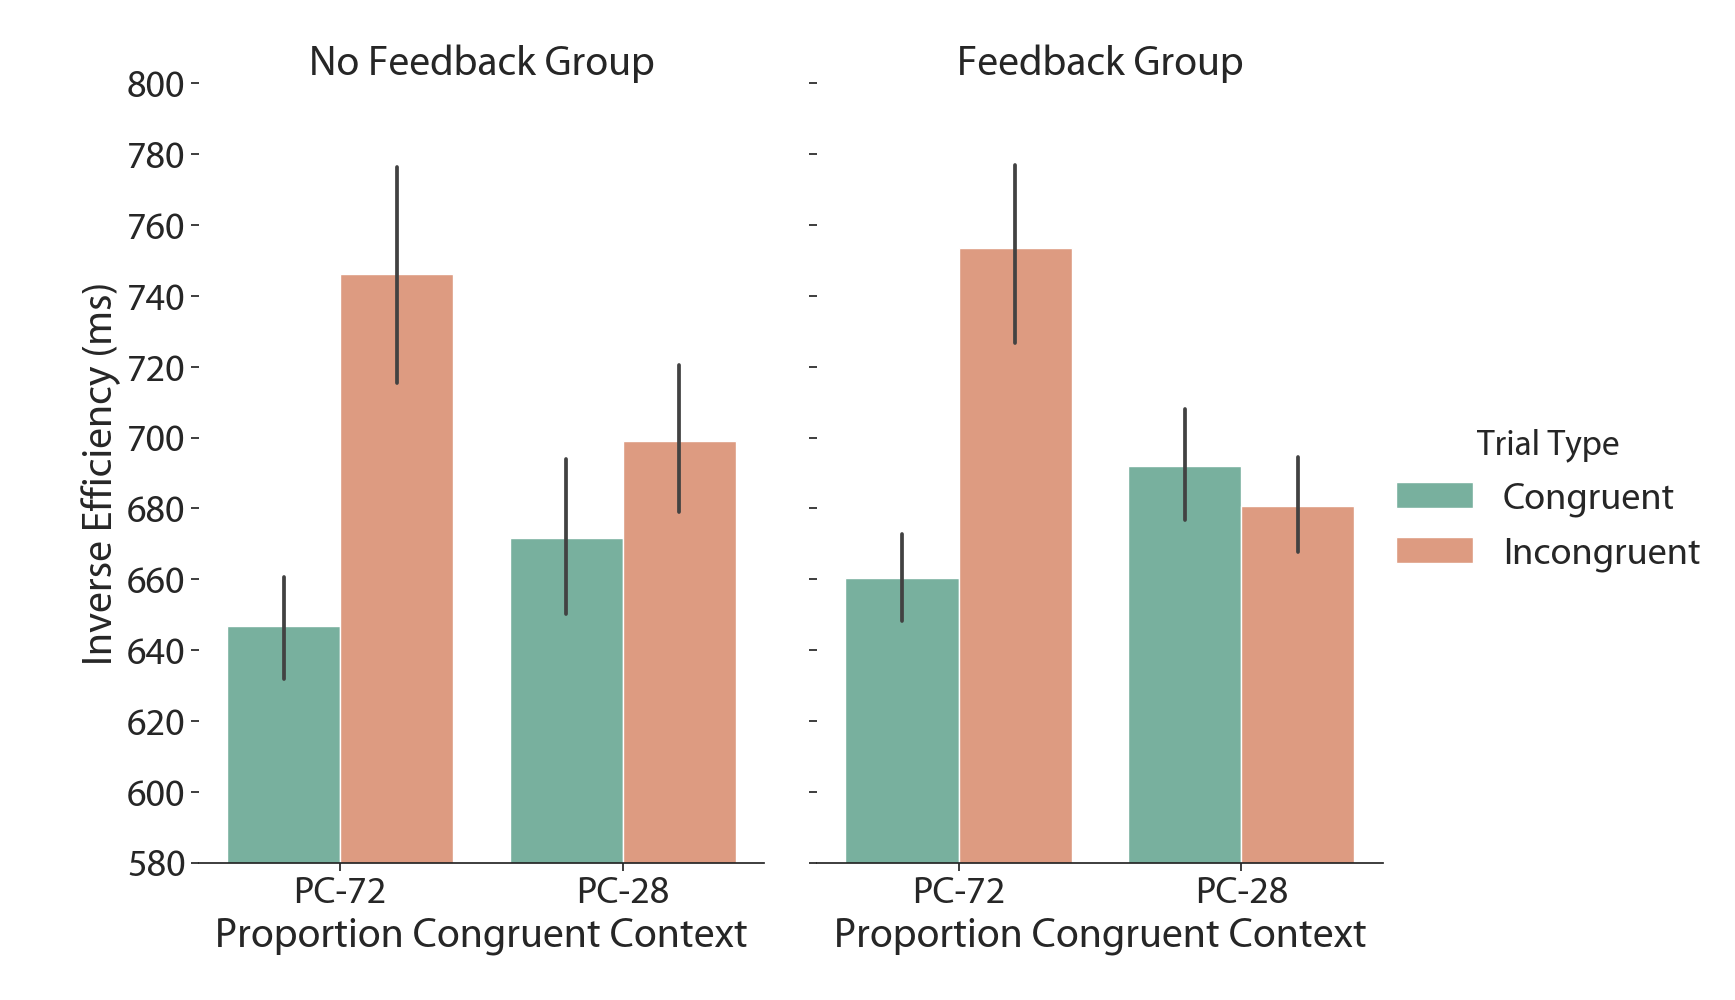

In [370]:
mybargraph("CueType","IE","TrialType","Feedback",["PC-72", "PC-28"],IE_all,"Proportion Congruent Context","Inverse Efficiency (ms)","Experiment 2b Biased ISPC/LWPC Items","Trial Type",580,800,"LWPC_IE_biased.png",20)

<IPython.core.display.Javascript object>


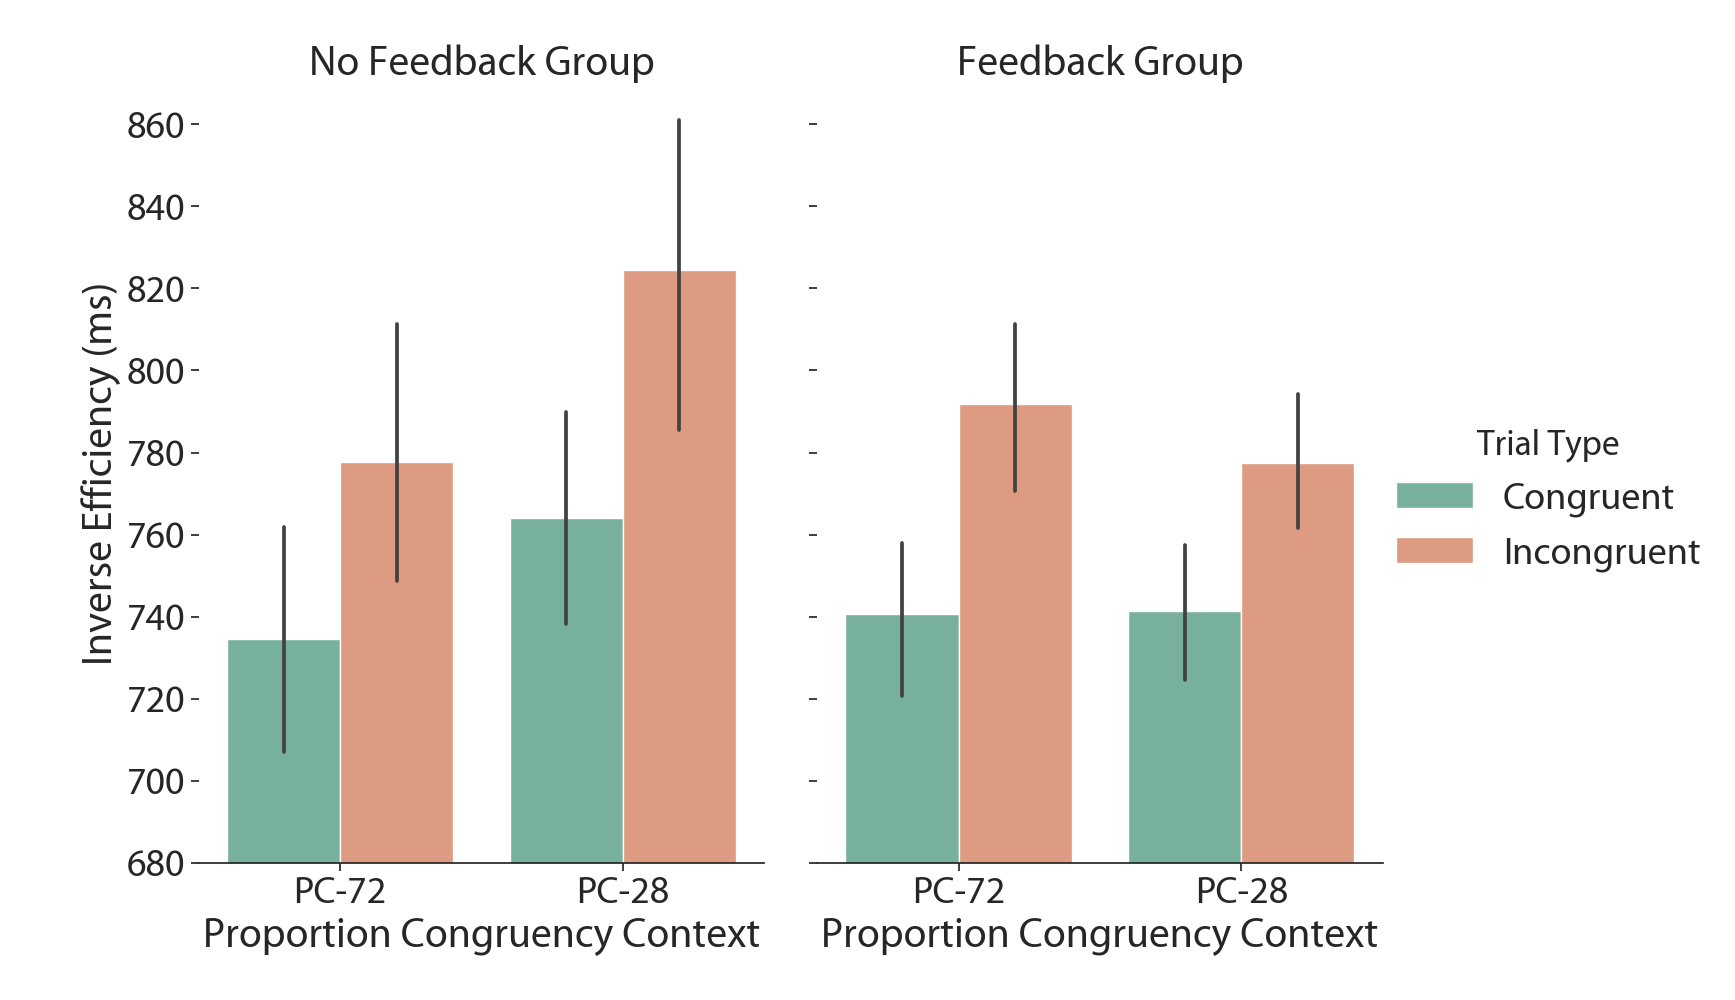

In [371]:
mybargraph("CueType","IE","TrialType","Feedback",["PC-72", "PC-28"],IE_all_T,"Proportion Congruency Context","Inverse Efficiency (ms)","Experiment 2b","Trial Type",680,870,"LWPC_IE_unbiased.png",20)

In [372]:
%%writefile IE_Anova.R

install.packages("psych",repos='https://mirrors.nics.utk.edu/cran/')
install.packages("ez",repos='https://mirrors.nics.utk.edu/cran/')
library(psych)
library(ez)

rawIEData <- read.csv('IE_Main.csv')

rawIEData$SubjectID = as.factor(rawIEData$SubjectID)
rawIEData$CueType = as.factor(rawIEData$CueType)
rawIEData$TrialType = as.factor(rawIEData$TrialType)
rawIEData$Feedback = as.factor(rawIEData$Feedback)
rawIEData$BlockOrder = as.factor(rawIEData$BlockOrder)

SC_RT_runANOVA <- ezANOVA(data=as.data.frame(rawIEData),
                                  dv=.(IE),
                                  wid=.(SubjectID),
                                  within=.(CueType, TrialType),
                                  between=.(Feedback, BlockOrder),
                                  detailed=TRUE)
print(SC_RT_runANOVA)

#

rawIEData_T <- read.csv('IE_transfer.csv')

rawIEData_T$SubjectID = as.factor(rawIEData_T$SubjectID)
rawIEData_T$CueType = as.factor(rawIEData_T$CueType)
rawIEData_T$TrialType = as.factor(rawIEData_T$TrialType)
rawIEData_T$Feedback = as.factor(rawIEData_T$Feedback)
rawIEData_T$BlockOrder = as.factor(rawIEData_T$BlockOrder)

SCT_RT_runANOVA <- ezANOVA(data=as.data.frame(rawIEData_T),
                                  dv=.(IE),
                                  wid=.(SubjectID),
                                  within=.(CueType, TrialType),
                                  between=.(Feedback, BlockOrder),
                                  detailed=TRUE)
print(SCT_RT_runANOVA)

Overwriting IE_Anova.R


In [373]:
! Rscript IE_Anova.R

package 'psych' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cb383\AppData\Local\Temp\RtmpQl7mwk\downloaded_packages
package 'ez' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cb383\AppData\Local\Temp\RtmpQl7mwk\downloaded_packages
$ANOVA
                                  Effect DFn DFd          SSn       SSd
1                            (Intercept)   1 116 2.310483e+08 7971817.4
2                               Feedback   1 116 4.055742e+03 7971817.4
3                             BlockOrder   1 116 1.531772e+05 7971817.4
5                                CueType   1 116 3.004723e+04 1626425.9
9                              TrialType   1 116 3.248875e+05  906467.4
4                    Feedback:BlockOrder   1 116 3.167505e+04 7971817.4
6                       Feedback:CueType   1 116 2.648343e+03 1626425.9
7                     BlockOrder:CueType   1 116 7.114055e+04 1626425.9
10                  

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/psych_1.8.12.zip'
Content type 'application/zip' length 5908111 bytes (5.6 MB)
downloaded 5.6 MB

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/ez_4.4-0.zip'
Content type 'application/zip' length 332373 bytes (324 KB)
downloaded 324 KB

Warning message:
package 'psych' was built under R version 3.4.4 
Warning message:
package 'ez' was built under R version 3.4.4 


Some things to observe:

* for *unbiased* items, there is an interaction between Cue Type x Trial Type x Block Order.

* for *biased* items, there is a Cue Type x Trial Type interaction, which is not qualified by a higher-order interaction with block order or feedback group.

Interestingly, in Experiment 2a, we found that the interaction between Cue Type and Trial Type for unbiased items was qualified by both Block Order and Feedback group. It will be interesting what patterns come out when the data are combined.

### Now that we've looked at our ANOVAs, let's calculate the means to report in the manuscript

In [374]:
#main effect of congruency for RT
maineffectcongruency=cdat.loc[cdat['Task']=='Main'].loc[cdat['Item']!='PC-50'].groupby(['subject','Congruency'])['RT'].mean()
grpmean = pd.Series.mean(maineffectcongruency, level=1)
round(grpmean), grpmean[1] - grpmean[0]

#PC x Block Order
PC_BO=cdat.loc[cdat['Task']=='Main'].loc[cdat['Item']!='PC-50'].loc[cdat['BlockOrder']=='IncongFirst'].groupby(['subject','Item'])['RT'].mean()
grpmean = pd.Series.mean(PC_BO, level=1)
round(grpmean), grpmean[1] - grpmean[0]

PC_BO2=cdat.loc[cdat['Task']=='Main'].loc[cdat['Item']!='PC-50'].loc[cdat['BlockOrder']=='CongFirst'].groupby(['subject','Item'])['RT'].mean()
grpmean = pd.Series.mean(PC_BO2, level=1)
round(grpmean), grpmean[1] - grpmean[0]

#congruency x feedback
CongFB_No=cdat.loc[cdat['Task']=='Main'].loc[cdat['Item']!='PC-50'].loc[cdat['Feedback']=='NoFeedback'].groupby(['subject','Congruency'])['RT'].mean()
grpmean = pd.Series.mean(CongFB_No, level=1)
(grpmean), (grpmean[1] - grpmean[0])

CongFB=cdat.loc[cdat['Task']=='Main'].loc[cdat['Item']!='PC-50'].loc[cdat['Feedback']=='Feedback'].groupby(['subject','Congruency'])['RT'].mean()
grpmean = pd.Series.mean(CongFB, level=1)
(grpmean), (grpmean[1] - grpmean[0])

#PC x congruency interaction:
SC_RT_FB.RTs.mean()
SC_RT_NoFB.RTs.mean()

#PC x congruency x block order:
PC_BO_CongNFB=cdat.loc[cdat['Task']=='Main'].loc[cdat['Item']!='PC-50'].loc[cdat['BlockOrder']=='IncongFirst'].loc[cdat['Feedback']=='NoFeedback'].groupby(['subject','ContextCong'])['RT'].mean()
grpmean = pd.Series.mean(PC_BO_CongNFB, level=1)
(grpmean), round((grpmean[3] - grpmean[2]) - (grpmean[1] - grpmean[0]))

PC_BO_CongFB=cdat.loc[cdat['Task']=='Main'].loc[cdat['Item']!='PC-50'].loc[cdat['BlockOrder']=='IncongFirst'].loc[cdat['Feedback']=='Feedback'].groupby(['subject','ContextCong'])['RT'].mean()
grpmean = pd.Series.mean(PC_BO_CongFB, level=1)
(grpmean), round((grpmean[3] - grpmean[2]) - (grpmean[1] - grpmean[0]))

PC_BO_CongNFB2=cdat.loc[cdat['Task']=='Main'].loc[cdat['Item']!='PC-50'].loc[cdat['BlockOrder']=='CongFirst'].loc[cdat['Feedback']=='NoFeedback'].groupby(['subject','ContextCong'])['RT'].mean()
grpmean = pd.Series.mean(PC_BO_CongNFB2, level=1)
(grpmean), round((grpmean[3] - grpmean[2]) - (grpmean[1] - grpmean[0]))

PC_BO_CongFB2=cdat.loc[cdat['Task']=='Main'].loc[cdat['Item']!='PC-50'].loc[cdat['BlockOrder']=='CongFirst'].loc[cdat['Feedback']=='Feedback'].groupby(['subject','ContextCong'])['RT'].mean()
grpmean = pd.Series.mean(PC_BO_CongFB2, level=1)
(grpmean), round((grpmean[3] - grpmean[2]) - (grpmean[1] - grpmean[0]))

(Congruency
 Congruent      613.0
 Incongruent    627.0
 Name: RT, dtype: float64, 13.92455512913159)

(Item
 PC-15    623.0
 PC-85    598.0
 Name: RT, dtype: float64, -25.18012962556702)

(Item
 PC-15    625.0
 PC-85    634.0
 Name: RT, dtype: float64, 8.885348588601005)

(Congruency
 Congruent      605.102755
 Incongruent    623.836446
 Name: RT, dtype: float64, 18.733690819306958)

(Congruency
 Congruent      620.970244
 Incongruent    630.085663
 Name: RT, dtype: float64, 9.115419438956792)

18.88523884935429

14.94724197871871

(ContextCong
 HighC     606.560360
 HighIC    615.154728
 LowC      577.655959
 LowIC     611.720794
 Name: RT, dtype: float64, 25.0)

(ContextCong
 HighC     627.910263
 HighIC    632.770394
 LowC      609.487780
 LowIC     629.707497
 Name: RT, dtype: float64, 15.0)

(ContextCong
 HighC     612.838191
 HighIC    630.144998
 LowC      630.929364
 LowIC     652.660189
 Name: RT, dtype: float64, 4.0)

(ContextCong
 HighC     622.988351
 HighIC    623.753164
 LowC      630.925216
 LowIC     654.100922
 Name: RT, dtype: float64, 22.0)

In [375]:
#main effect of congruency for Accuracy
maineffectcongruency=adat.loc[adat['Task']=='Main'].loc[adat['Item']!='PC-50'].groupby(['subject','Congruency'])['Accuracy'].mean()
grpmean = pd.Series.mean(maineffectcongruency, level=1)
grpmean, grpmean[1] - grpmean[0]

#PC x congruency interaction
SC_ACC_FB.ACC.mean()*100
SC_ACC_NoFB.ACC.mean()*100

#PC x congruency x block order:
PC_BO_CongNFB=adat.loc[adat['Task']=='Main'].loc[adat['Item']!='PC-50'].loc[adat['BlockOrder']=='IncongFirst'].loc[adat['Feedback']=='NoFeedback'].groupby(['subject','ContextCong'])['Accuracy'].mean()
grpmean = pd.Series.mean(PC_BO_CongNFB, level=1)
(grpmean), ((grpmean[3] - grpmean[2]) - (grpmean[1] - grpmean[0]))*100

PC_BO_CongFB=adat.loc[adat['Task']=='Main'].loc[adat['Item']!='PC-50'].loc[adat['BlockOrder']=='IncongFirst'].loc[adat['Feedback']=='Feedback'].groupby(['subject','ContextCong'])['Accuracy'].mean()
grpmean = pd.Series.mean(PC_BO_CongFB, level=1)
(grpmean), ((grpmean[3] - grpmean[2]) - (grpmean[1] - grpmean[0]))*100

PC_BO_CongNFB2=adat.loc[adat['Task']=='Main'].loc[adat['Item']!='PC-50'].loc[adat['BlockOrder']=='CongFirst'].loc[adat['Feedback']=='NoFeedback'].groupby(['subject','ContextCong'])['Accuracy'].mean()
grpmean = pd.Series.mean(PC_BO_CongNFB2, level=1)
(grpmean), ((grpmean[3] - grpmean[2]) - (grpmean[1] - grpmean[0]))*100

PC_BO_CongFB2=adat.loc[adat['Task']=='Main'].loc[adat['Item']!='PC-50'].loc[adat['BlockOrder']=='CongFirst'].loc[adat['Feedback']=='Feedback'].groupby(['subject','ContextCong'])['Accuracy'].mean()
grpmean = pd.Series.mean(PC_BO_CongFB2, level=1)
(grpmean), ((grpmean[3] - grpmean[2]) - (grpmean[1] - grpmean[0]))*100

(Congruency
 Congruent      0.939463
 Incongruent    0.913862
 Name: Accuracy, dtype: float64, -0.02560096153846181)

-8.352272727272728

-4.005681818181818

(ContextCong
 HighC     0.945833
 HighIC    0.907576
 LowC      0.950379
 LowIC     0.900000
 Name: Accuracy, dtype: float64, -1.212121212121231)

(ContextCong
 HighC     0.915625
 HighIC    0.925947
 LowC      0.951894
 LowIC     0.892708
 Name: Accuracy, dtype: float64, -6.950757575757594)

(ContextCong
 HighC     0.910417
 HighIC    0.911553
 LowC      0.933523
 LowIC     0.866667
 Name: Accuracy, dtype: float64, -6.799242424242447)

(ContextCong
 HighC     0.910417
 HighIC    0.934659
 LowC      0.935795
 LowIC     0.862500
 Name: Accuracy, dtype: float64, -9.753787878787845)

In [376]:
#main effect of congruency for IE
maineffectcongruency=IE_all.groupby(['TrialType'])['IE'].mean()
round(maineffectcongruency)

#PC x block order
PC_BO=IE_all.loc[IE_all['BlockOrder']=='IncongFirst'].groupby(['CueType'])['IE'].mean()
round(PC_BO)

PC_BO2=IE_all.loc[IE_all['BlockOrder']=='CongFirst'].groupby(['CueType'])['IE'].mean()
round(PC_BO2)

#PC x congruency interaction - by FB grp
PCcongint = IE_all.groupby(['SubjectID', 'Feedback'])['Effect'].mean()
grpmean = pd.Series.mean(PCcongint, level=1)
round(grpmean)

TrialType
Congruent      668.0
Incongruent    720.0
Name: IE, dtype: float64

CueType
PC-28    680.0
PC-72    672.0
Name: IE, dtype: float64

CueType
PC-28    692.0
PC-72    732.0
Name: IE, dtype: float64

Feedback
NoFeedback     72.0
Feedback      104.0
Name: Effect, dtype: float64

In [377]:
#main effect of congruency for RT for LWPC items
maineffectcongruency=cdat.loc[cdat['Task']=='Main'].loc[cdat['Item']=='PC-50'].groupby(['subject','Congruency'])['RT'].mean()
grpmean = pd.Series.mean(maineffectcongruency, level=1)
round(grpmean), grpmean[1] - grpmean[0]

#main effect of PC for RT for LWPC items
maineffectPC=cdat.loc[cdat['Task']=='Main'].loc[cdat['Item']=='PC-50'].groupby(['subject','BlockType'])['RT'].mean()
grpmean = pd.Series.mean(maineffectPC, level=1)
round(grpmean), grpmean[1] - grpmean[0]

#PC x Block Order
PC_BO=cdat.loc[cdat['Task']=='Main'].loc[cdat['Item']=='PC-50'].loc[cdat['BlockOrder']=='IncongFirst'].groupby(['subject','BlockType'])['RT'].mean()
grpmean = pd.Series.mean(PC_BO, level=1)
round(grpmean), grpmean[1] - grpmean[0]

PC_BO2=cdat.loc[cdat['Task']=='Main'].loc[cdat['Item']=='PC-50'].loc[cdat['BlockOrder']=='CongFirst'].groupby(['subject','BlockType'])['RT'].mean()
grpmean = pd.Series.mean(PC_BO2, level=1)
round(grpmean), grpmean[1] - grpmean[0]

#PC x congruency interaction:
SCT_RT_FB.RTs.mean()
SCT_RT_NoFB.RTs.mean()

(Congruency
 Congruent      656.0
 Incongruent    673.0
 Name: RT, dtype: float64, 17.810534288862414)

(BlockType
 PC-28    668.0
 PC-72    661.0
 Name: RT, dtype: float64, -7.087384726653113)

(BlockType
 PC-28    663.0
 PC-72    648.0
 Name: RT, dtype: float64, -14.523326146625777)

(BlockType
 PC-28    673.0
 PC-72    674.0
 Name: RT, dtype: float64, 0.3485566933196651)

10.355330460258795

0.3182429155471008

In [378]:
#main effect of congruency for Accuracy
maineffectcongruency=adat.loc[adat['Task']=='Main'].loc[adat['Item']=='PC-50'].groupby(['subject','Congruency'])['Accuracy'].mean()
grpmean = pd.Series.mean(maineffectcongruency, level=1)
grpmean, grpmean[1] - grpmean[0]

#main effect of block order for Accuracy
maineffectBO=adat.loc[adat['Task']=='Main'].loc[adat['Item']=='PC-50'].groupby(['subject','BlockOrder'])['Accuracy'].mean()
grpmean = pd.Series.mean(maineffectBO, level=1)
grpmean, grpmean[1] - grpmean[0]

#PC x Block Order
PC_BO=adat.loc[adat['Task']=='Main'].loc[adat['Item']=='PC-50'].loc[adat['BlockOrder']=='IncongFirst'].groupby(['subject','BlockType'])['Accuracy'].mean()
grpmean = pd.Series.mean(PC_BO, level=1)
(grpmean), grpmean[1] - grpmean[0]

PC_BO2=adat.loc[adat['Task']=='Main'].loc[adat['Item']=='PC-50'].loc[adat['BlockOrder']=='CongFirst'].groupby(['subject','BlockType'])['Accuracy'].mean()
grpmean = pd.Series.mean(PC_BO2, level=1)
(grpmean), grpmean[1] - grpmean[0]

#PC x congruency x block order:
PC_BO_CongNFB=adat.loc[adat['Task']=='Main'].loc[adat['Item']=='PC-50'].loc[adat['BlockOrder']=='IncongFirst'].loc[adat['Feedback']=='NoFeedback'].groupby(['subject','ContextCong'])['Accuracy'].mean()
grpmean = pd.Series.mean(PC_BO_CongNFB, level=1)
(grpmean), ((grpmean[3] - grpmean[2]) - (grpmean[1] - grpmean[0]))*100

PC_BO_CongFB=adat.loc[adat['Task']=='Main'].loc[adat['Item']=='PC-50'].loc[adat['BlockOrder']=='IncongFirst'].loc[adat['Feedback']=='Feedback'].groupby(['subject','ContextCong'])['Accuracy'].mean()
grpmean = pd.Series.mean(PC_BO_CongFB, level=1)
(grpmean), ((grpmean[3] - grpmean[2]) - (grpmean[1] - grpmean[0]))*100

PC_BO_CongNFB2=adat.loc[adat['Task']=='Main'].loc[adat['Item']=='PC-50'].loc[adat['BlockOrder']=='CongFirst'].loc[adat['Feedback']=='NoFeedback'].groupby(['subject','ContextCong'])['Accuracy'].mean()
grpmean = pd.Series.mean(PC_BO_CongNFB2, level=1)
(grpmean), ((grpmean[3] - grpmean[2]) - (grpmean[1] - grpmean[0]))*100

PC_BO_CongFB2=adat.loc[adat['Task']=='Main'].loc[adat['Item']=='PC-50'].loc[adat['BlockOrder']=='CongFirst'].loc[adat['Feedback']=='Feedback'].groupby(['subject','ContextCong'])['Accuracy'].mean()
grpmean = pd.Series.mean(PC_BO_CongFB2, level=1)
(grpmean), ((grpmean[3] - grpmean[2]) - (grpmean[1] - grpmean[0]))*100

(Congruency
 Congruent      0.900833
 Incongruent    0.877083
 Name: Accuracy, dtype: float64, -0.023749999999999383)

(BlockOrder
 IncongFirst    0.903750
 CongFirst      0.874167
 Name: Accuracy, dtype: float64, -0.029583333333333295)

(BlockType
 PC-28    0.889167
 PC-72    0.918333
 Name: Accuracy, dtype: float64, 0.029166666666666563)

(BlockType
 PC-28    0.880625
 PC-72    0.867708
 Name: Accuracy, dtype: float64, -0.012916666666666798)

(ContextCong
 HighC     0.905000
 HighIC    0.868333
 LowC      0.920000
 LowIC     0.913333
 Name: Accuracy, dtype: float64, 2.9999999999999805)

(ContextCong
 HighC     0.906667
 HighIC    0.876667
 LowC      0.925833
 LowIC     0.914167
 Name: Accuracy, dtype: float64, 1.8333333333333535)

(ContextCong
 HighC     0.870833
 HighIC    0.857500
 LowC      0.893333
 LowIC     0.865000
 Name: Accuracy, dtype: float64, -1.5000000000000346)

(ContextCong
 HighC     0.908333
 HighIC    0.885833
 LowC      0.876667
 LowIC     0.835833
 Name: Accuracy, dtype: float64, -1.8333333333333535)

In [379]:
#main effect of congruency for IE
maineffectcongruency=IE_all_T.groupby(['TrialType'])['IE'].mean()
round(maineffectcongruency)

#main effect of block order for IE
maineffectPC=IE_all_T.groupby(['BlockOrder'])['IE'].mean()
round(maineffectPC)

#PC x block order
PC_BO=IE_all_T.loc[IE_all_T['BlockOrder']=='IncongFirst'].groupby(['CueType'])['IE'].mean()
round(PC_BO)

PC_BO2=IE_all_T.loc[IE_all_T['BlockOrder']=='CongFirst'].groupby(['CueType'])['IE'].mean()
round(PC_BO2)

#PC x feedback
PC_NFB=IE_all_T.loc[IE_all_T['Feedback']=='NoFeedback'].groupby(['CueType'])['IE'].mean()
round(PC_NFB), PC_NFB[1] - PC_NFB[0]

PC_FB=IE_all_T.loc[IE_all_T['Feedback']=='Feedback'].groupby(['CueType'])['IE'].mean()
round(PC_FB), PC_FB[1] - PC_FB[0]

#PC x congruency x block order interaction
PCCongBO = IE_all_T.groupby(['SubjectID', 'BlockOrder'])['Effect'].mean()
grpmean = pd.Series.mean(PCCongBO, level=1)
round(grpmean)

#3-way by feedback group
PCcongint = IE_all_T.groupby(['BlockOrder', 'Feedback'])['Effect'].mean()
round(PCcongint)

TrialType
Congruent      745.0
Incongruent    793.0
Name: IE, dtype: float64

BlockOrder
CongFirst      800.0
IncongFirst    738.0
Name: IE, dtype: float64

CueType
PC-28    761.0
PC-72    714.0
Name: IE, dtype: float64

CueType
PC-28    792.0
PC-72    808.0
Name: IE, dtype: float64

(CueType
 PC-28    794.0
 PC-72    756.0
 Name: IE, dtype: float64, -38.13683856139846)

(CueType
 PC-28    759.0
 PC-72    766.0
 Name: IE, dtype: float64, 6.684790599807229)

BlockOrder
IncongFirst   -29.0
CongFirst      27.0
Name: Effect, dtype: float64

BlockOrder   Feedback  
CongFirst    Feedback      35.0
             NoFeedback    18.0
IncongFirst  Feedback      -5.0
             NoFeedback   -53.0
Name: Effect, dtype: float64

### Is there a correlation between the biased and unbiased effects?

In Gonthier et al. (2016), the claim is made that the ISPC reflects reactive control and the LWPC reflects proactive control, so the difference in congruency for items that are biased at the list & item level *should not* relate to the difference in congruency for items that are only biased at the list level.

Here, note that we have a small sample (larger when all combined; then N = 180), but we can check if the correlation is nill or negative, as to be predicted.

In [380]:
def my_corr_graphs(x, y, ylabel, xlabel, figname, selectsubs, corrxvalue, corryvalue):
    sns.jointplot(x=x, y=y, kind="reg", height=11, ratio=2, color = 'g');
    plt.ylabel(ylabel, fontweight="bold");
    plt.xlabel(xlabel, fontweight="bold");
    plb.savefig(figurepath+figname, dpi = 300)
    regstat = stats.linregress(x,y)
    
    if selectsubs == 1:
        corrx = x/corrxvalue
        corry = y/corryvalue
    else:
        corrx = x.reset_index(drop=True)/corrxvalue
        corry = y.reset_index(drop=True)/corryvalue
        
    corrstat = stats.linregress(corrx,corry)
    return regstat, corrstat

INVERSE EFFICIENCY

for the feedback group...?

<IPython.core.display.Javascript object>


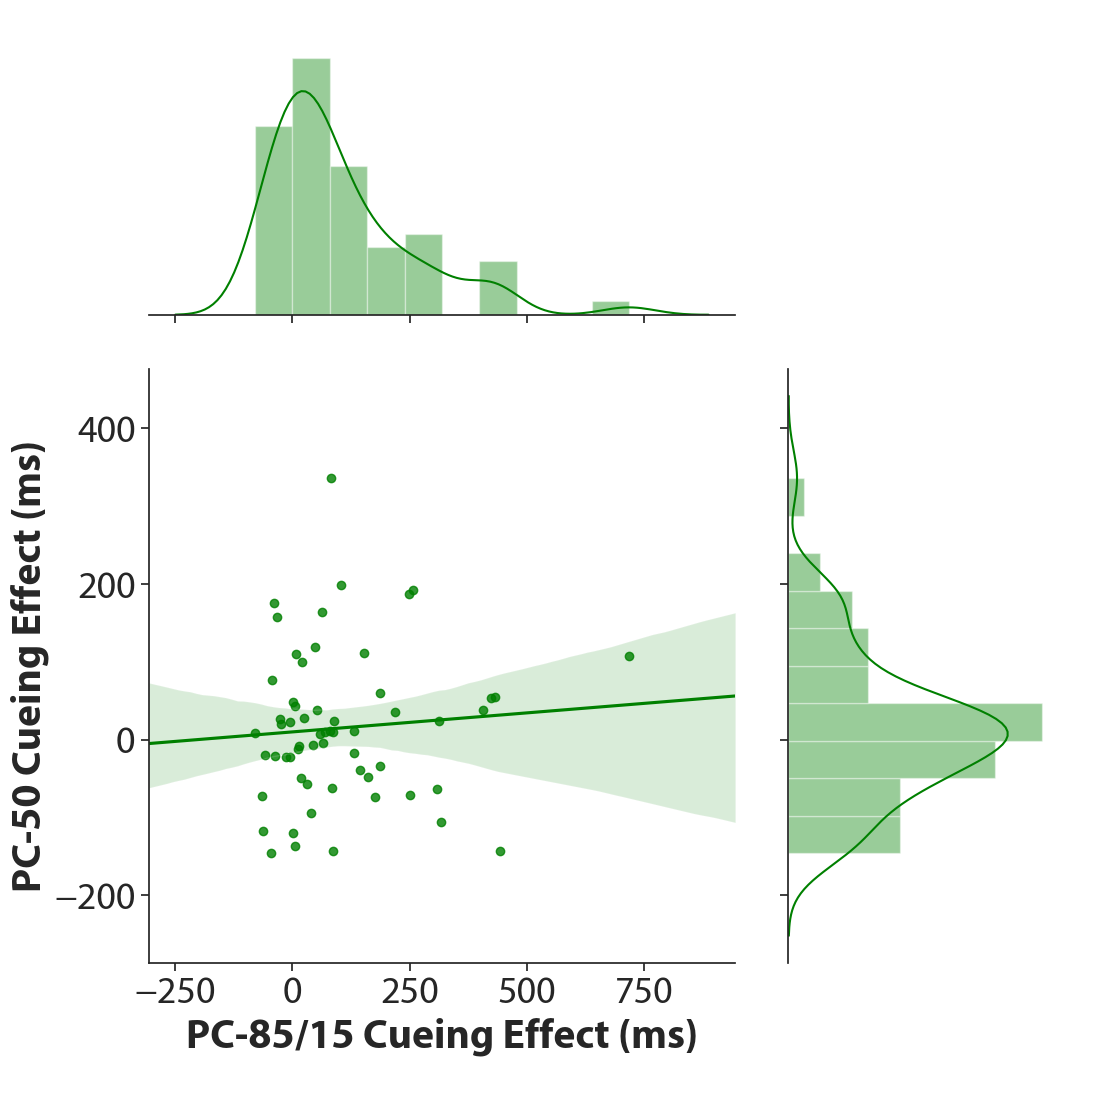

(LinregressResult(slope=0.04889836294553164, intercept=9.938362536812736, rvalue=0.07913189863379495, pvalue=0.547838248089184, stderr=0.08088439041588365),
 LinregressResult(slope=0.05445884270416995, intercept=0.010193628052737312, rvalue=0.0843815038083309, pvalue=0.5215151461094849, stderr=0.08444141057728452))

In [381]:
my_corr_graphs(avgIEmain.loc[avgIEmain.Feedback=="Feedback"].Effect, avgIE_T.loc[avgIE_T.Feedback=="Feedback"].Effect, 'PC-50 Cueing Effect (ms)', 'PC-85/15 Cueing Effect (ms)', "SC_SCT_All_IE_FB.png", 1, avgIEmain.loc[avgIEmain.Feedback=="Feedback"].OverallIE, avgIE_T.loc[avgIE_T.Feedback=="Feedback"].OverallIE)

for the no feedback group...?

<IPython.core.display.Javascript object>


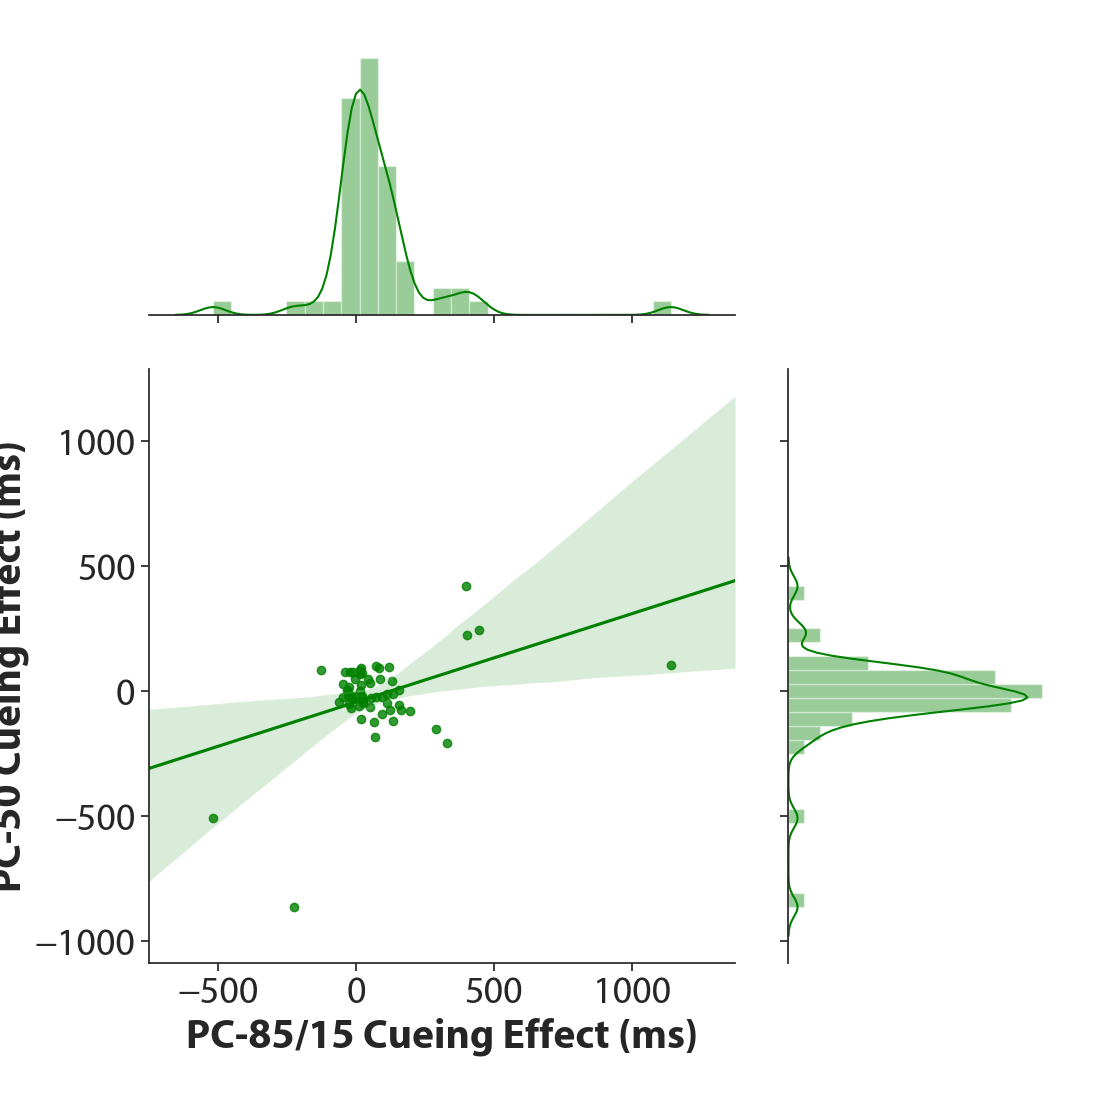

(LinregressResult(slope=0.35351969620318535, intercept=-42.68731909471326, rvalue=0.43208987225758855, pvalue=0.0005658720120498482, stderr=0.09688364621205832),
 LinregressResult(slope=0.411506103351383, intercept=-0.05009550571344731, rvalue=0.4913254495813361, pvalue=6.713362969590171e-05, stderr=0.09578538374458011))

In [382]:
my_corr_graphs(avgIEmain.loc[avgIEmain.Feedback=="NoFeedback"].Effect, avgIE_T.loc[avgIE_T.Feedback=="NoFeedback"].Effect, 'PC-50 Cueing Effect (ms)', 'PC-85/15 Cueing Effect (ms)', "SC_SCT_All_IE_NoFB.png", 1, avgIEmain.loc[avgIEmain.Feedback=="NoFeedback"].OverallIE, avgIE_T.loc[avgIE_T.Feedback=="NoFeedback"].OverallIE)

for all subjects...?

<IPython.core.display.Javascript object>


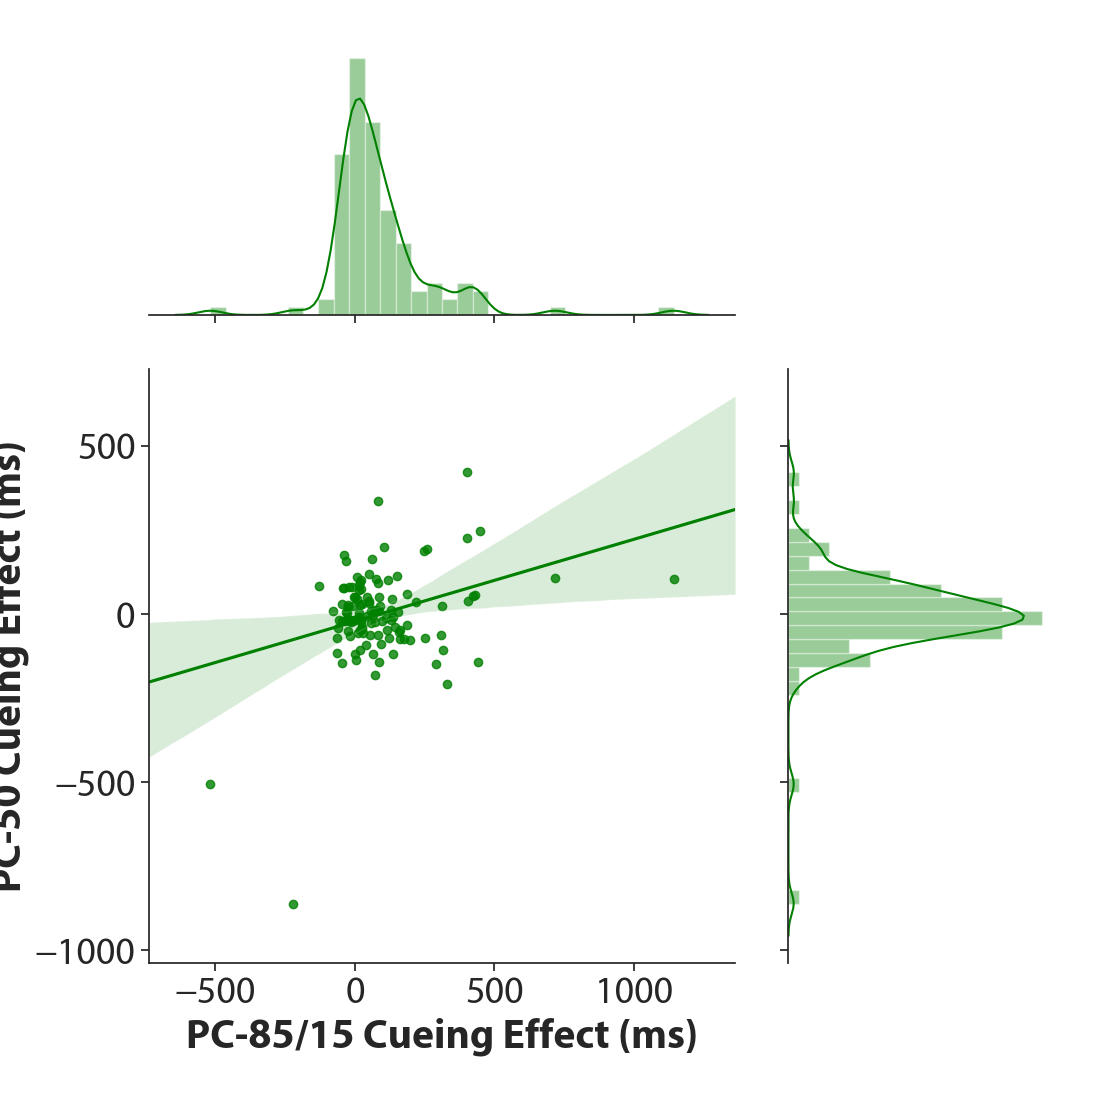

(LinregressResult(slope=0.24433182684098165, intercept=-22.626836959688543, rvalue=0.3253245877339196, pvalue=0.0002883004916222539, stderr=0.06537786282312753),
 LinregressResult(slope=0.2668960740846891, intercept=-0.028106562465505, rvalue=0.35076467301976766, pvalue=8.573903866320347e-05, stderr=0.06559583324415481))

In [383]:
my_corr_graphs(avgIEmain.Effect, avgIE_T.Effect, 'PC-50 Cueing Effect (ms)', 'PC-85/15 Cueing Effect (ms)', "SC_SCT_All_IE.png", 1, avgIEmain.OverallIE, avgIE_T.OverallIE)

Here, we find some suggestion of a *positive* correlation between inverse efficiency scores for the LWPC and biased LWPC/ISPC effects. Granted, correlations stabilize at 200-250 observations, and this experiment is 120 for the all subjects graph... so even though we correct for overall IE (shrinking some of those outlier points), it's not the sample we'd need to be confident.

REACTION TIME

for the feedback group...?

<IPython.core.display.Javascript object>


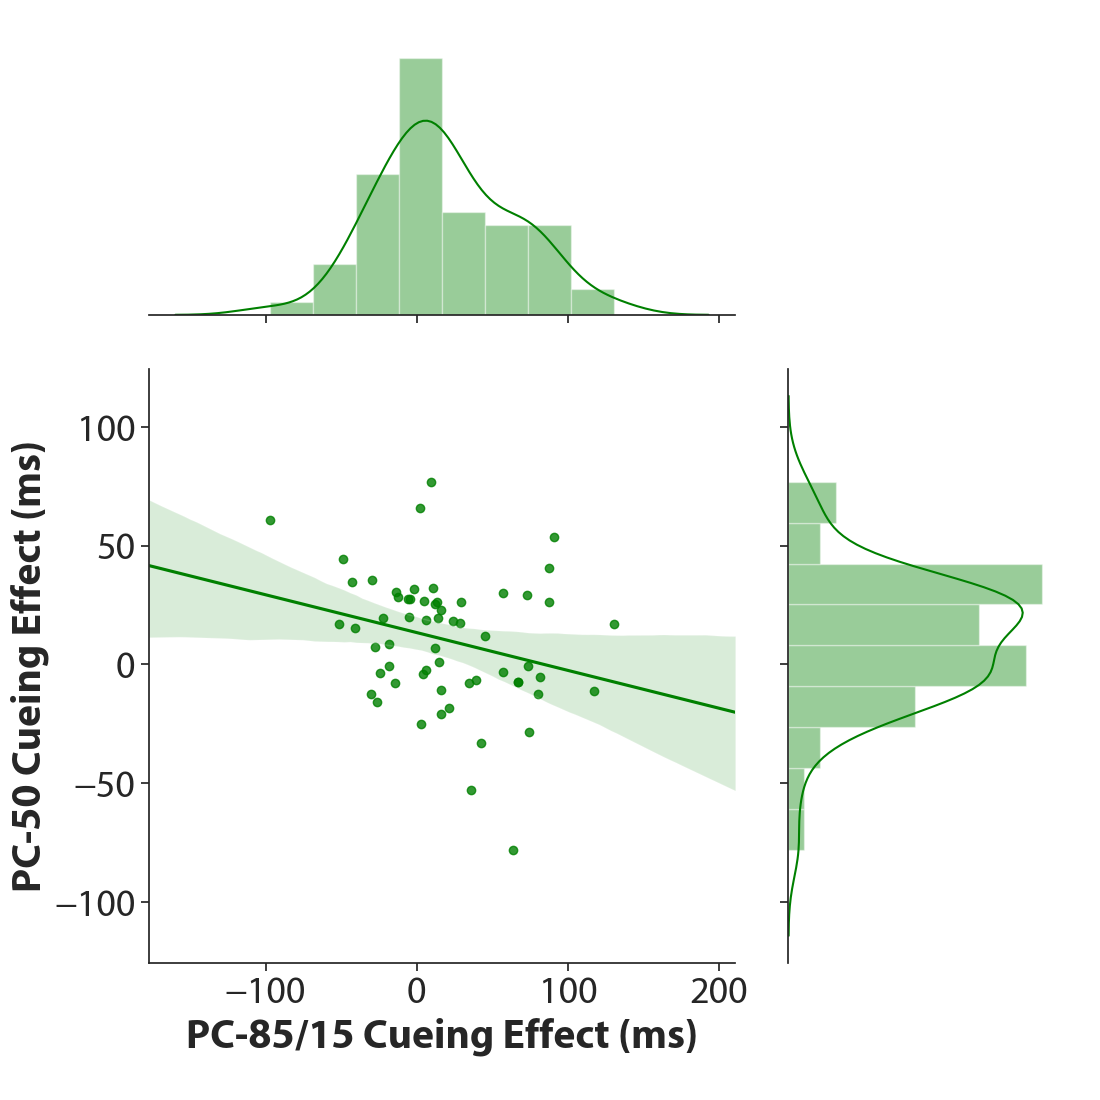

(LinregressResult(slope=-0.15925718892866045, intercept=13.362940511653289, rvalue=-0.2606912069985703, pvalue=0.04424526559664081, stderr=0.07744189358646958),
 LinregressResult(slope=-0.1361095469271293, intercept=0.02050934067724869, rvalue=-0.238175648211857, pvalue=0.06686782041269698, stderr=0.07287789000498722))

In [384]:
my_corr_graphs(SC_RT_FB.RTs, SCT_RT_FB.RTs, 'PC-50 Cueing Effect (ms)', 'PC-85/15 Cueing Effect (ms)', "SC_SCT_FB.png", 1, MainRT_FB.RT, RT_FB_T.RT)

for the no feedback group...?

<IPython.core.display.Javascript object>


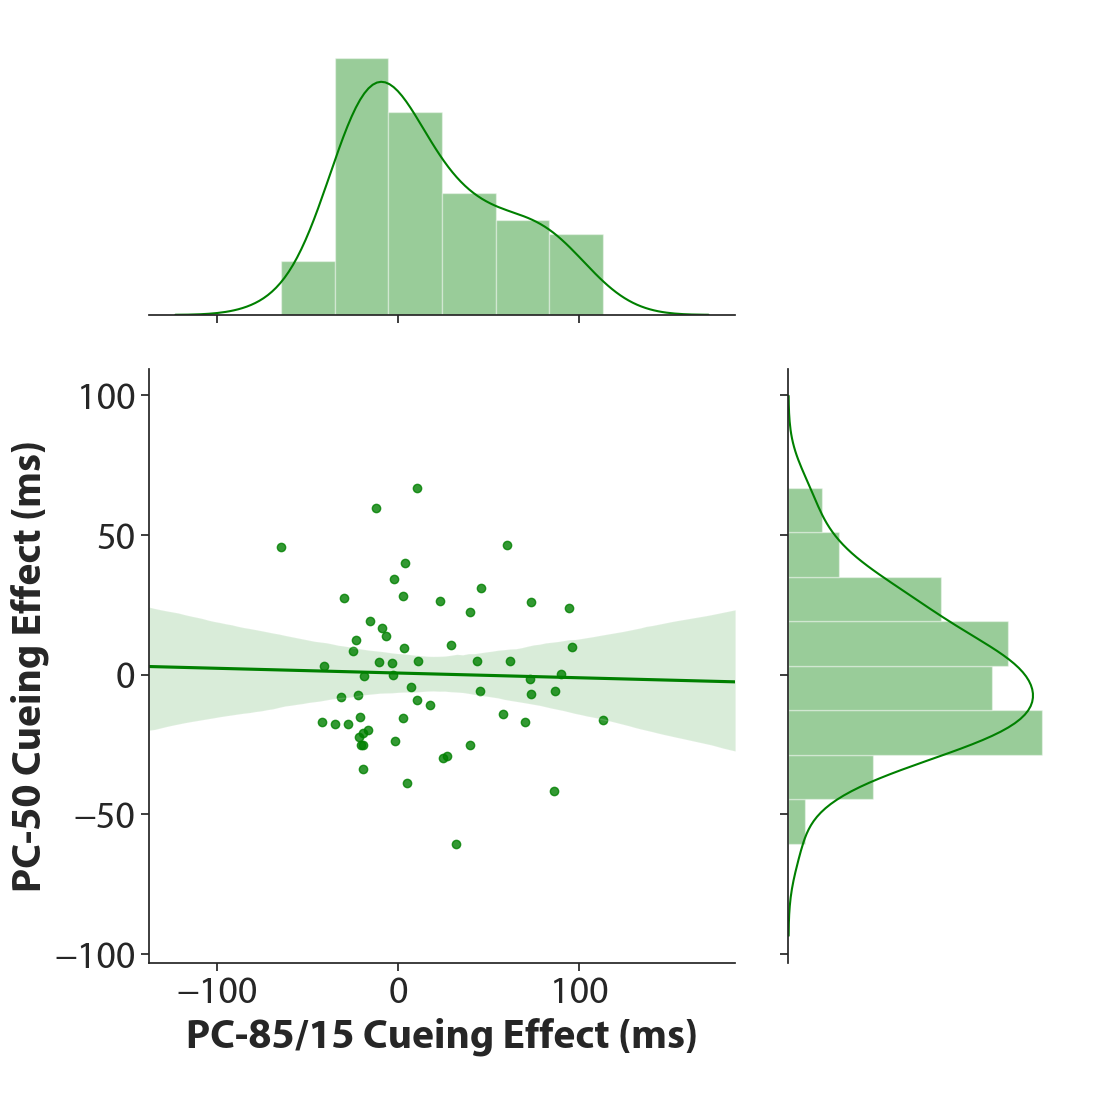

(LinregressResult(slope=-0.016975350806756433, intercept=0.571977591729327, rvalue=-0.02801261792846567, pvalue=0.8317466538904228, stderr=0.07953908663711524),
 LinregressResult(slope=-0.030266381383535264, intercept=0.0016023032263411579, rvalue=-0.05259205889358707, pvalue=0.6898319368220087, stderr=0.07546140471785356))

In [385]:
my_corr_graphs(SC_RT_NoFB.RTs, SCT_RT_NoFB.RTs, 'PC-50 Cueing Effect (ms)', 'PC-85/15 Cueing Effect (ms)', "SC_SCT_NoFB.png", 1, MainRT_NoFB.RT, RT_NoFB_T.RT)

across all subjects...?

<IPython.core.display.Javascript object>


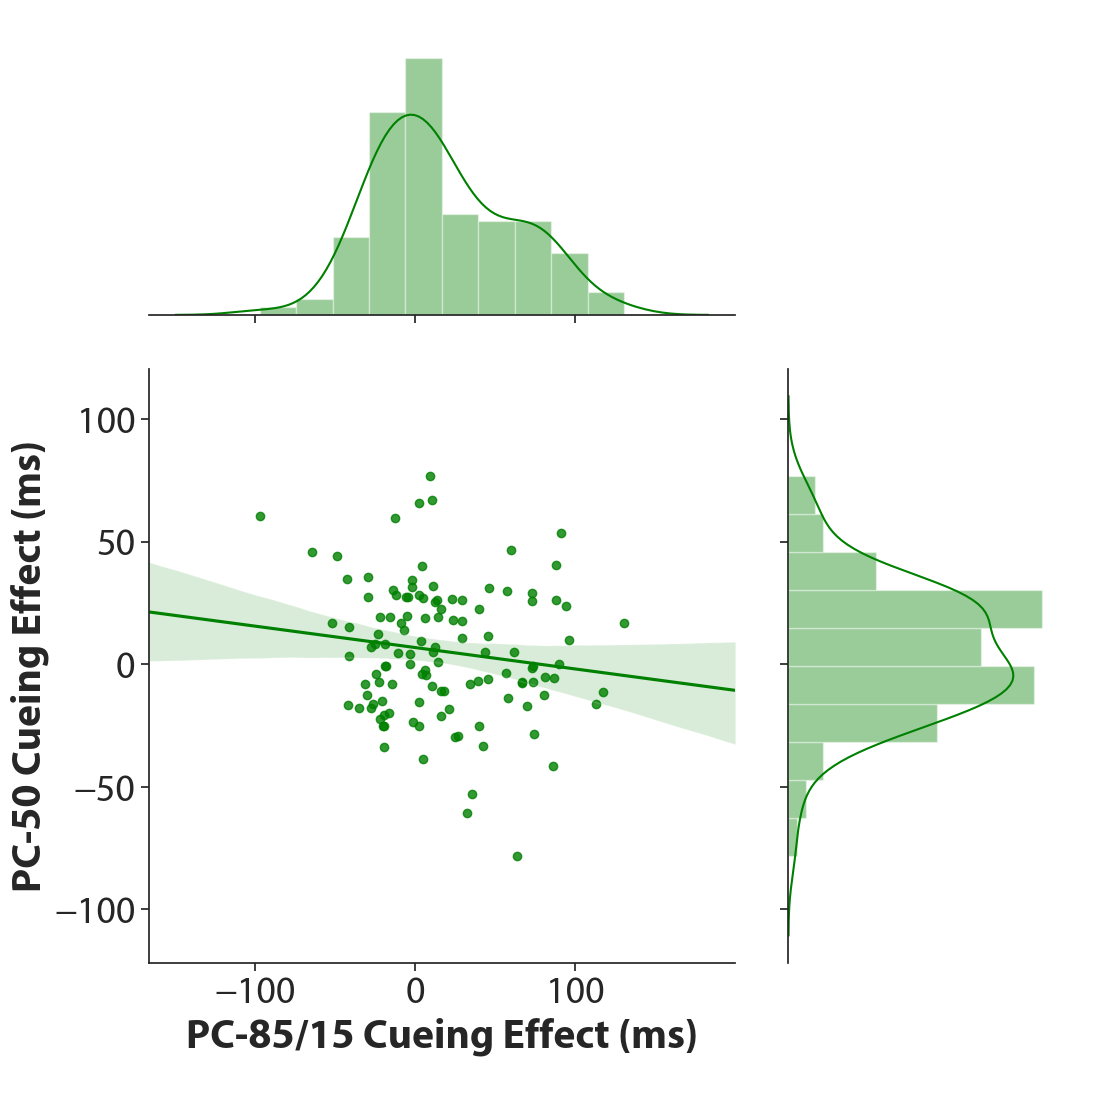

(LinregressResult(slope=-0.08745482484343596, intercept=6.8161935303219625, rvalue=-0.14125679617272532, pvalue=0.12382347212668487, stderr=0.05642307664172105),
 LinregressResult(slope=-0.08079928428692819, intercept=0.010836349277283677, rvalue=-0.138435844266127, pvalue=0.1315837063301853, stderr=0.05321279225213076))

In [386]:
my_corr_graphs(SC_RT.RTs, SCT_RT.RTs, 'PC-50 Cueing Effect (ms)', 'PC-85/15 Cueing Effect (ms)', "SC_SCT_All.png", 0, overallMainRT.RT, overallRT_T.RT)

With RT, we don't find a significant relationship between the two effects (although it is headed in the negative direction, as argued in Gonthier et al. (2016)). We'll have to see whether the relationship with inverse efficiency scores holds up with N = 180.

#### What about for accuracy?

for the feedback group...?

<IPython.core.display.Javascript object>


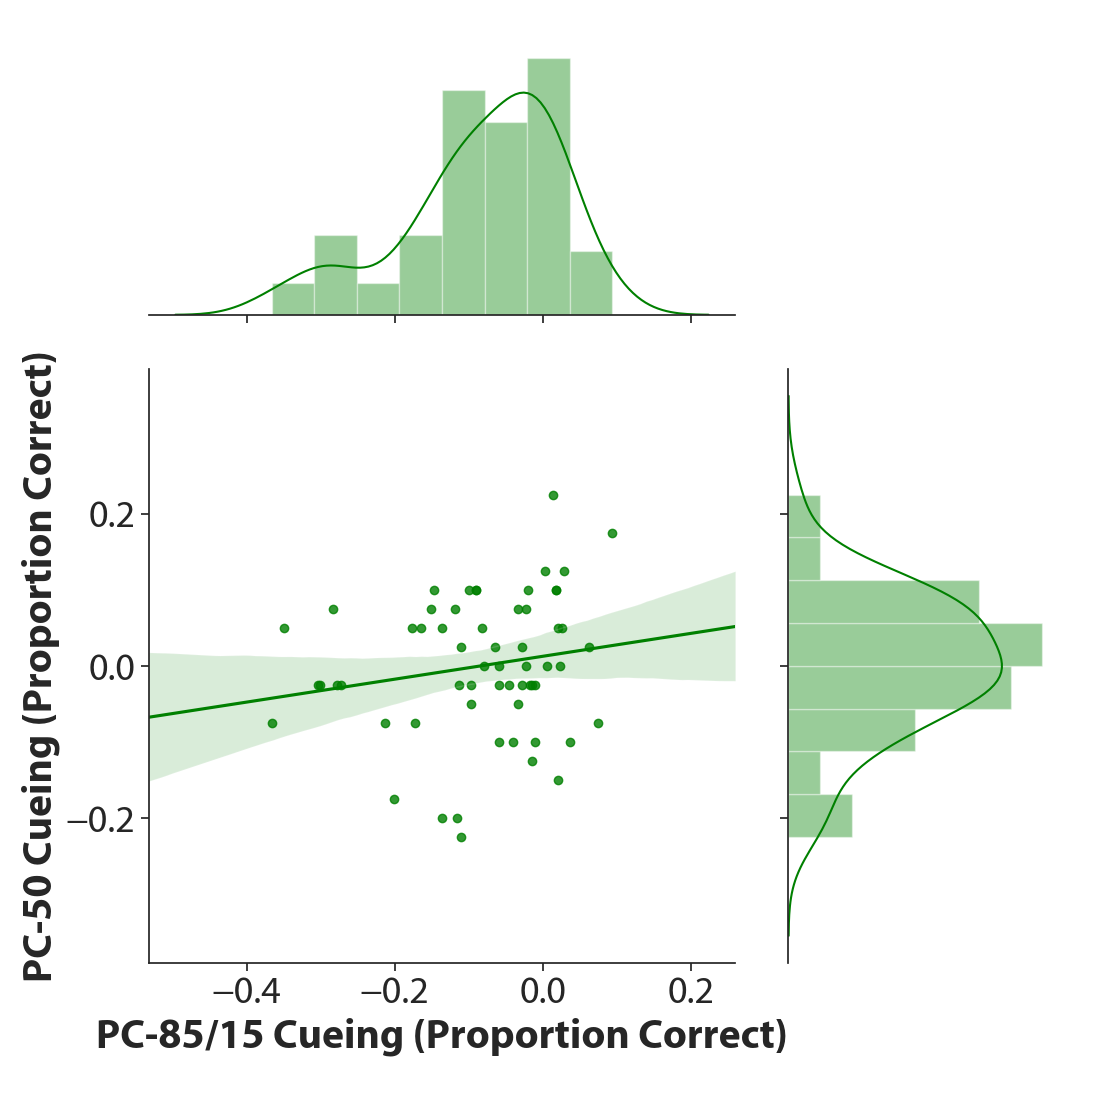

(LinregressResult(slope=0.1504970584191788, intercept=0.012569924765692762, rvalue=0.17476326701098815, pvalue=0.18170034386487804, stderr=0.11133412866485147),
 LinregressResult(slope=0.15911762556884382, intercept=0.012877221070904976, rvalue=0.18052649822254718, pvalue=0.16749212654189394, stderr=0.1138331259243216))

In [387]:
my_corr_graphs(SC_ACC_FB.ACC, SCT_ACC_FB.ACC, 'PC-50 Cueing (Proportion Correct)', 'PC-85/15 Cueing (Proportion Correct)', "SC_SCT_FB_ACC.png", 1, MainACC_FB.Accuracy, ACC_FB_T.Accuracy)

for the no feedback group...?

<IPython.core.display.Javascript object>


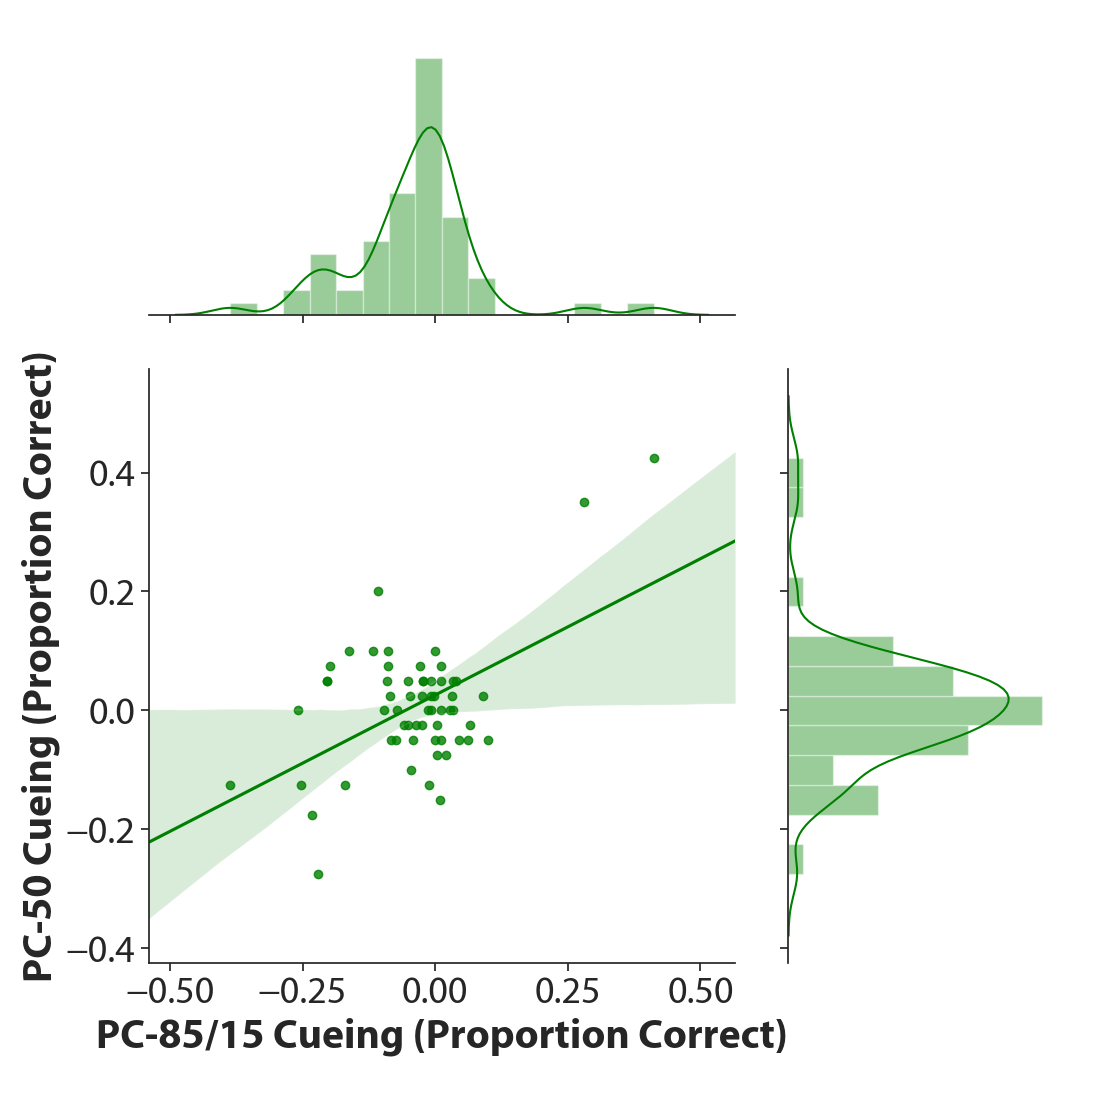

(LinregressResult(slope=0.4584650749739167, intercept=0.02586465215094383, rvalue=0.5179598209405482, pvalue=2.2494828237911667e-05, stderr=0.09941866941160946),
 LinregressResult(slope=0.491145276891619, intercept=0.03100473487533568, rvalue=0.5625536807280545, pvalue=2.895727067134525e-06, stderr=0.09477894301727775))

In [388]:
my_corr_graphs(SC_ACC_NoFB.ACC, SCT_ACC_NoFB.ACC, 'PC-50 Cueing (Proportion Correct)', 'PC-85/15 Cueing (Proportion Correct)', "SC_SCT_NoFB_ACC.png", 1, MainACC_NoFB.Accuracy, ACC_NoFB_T.Accuracy)

across all subjects ...?

<IPython.core.display.Javascript object>


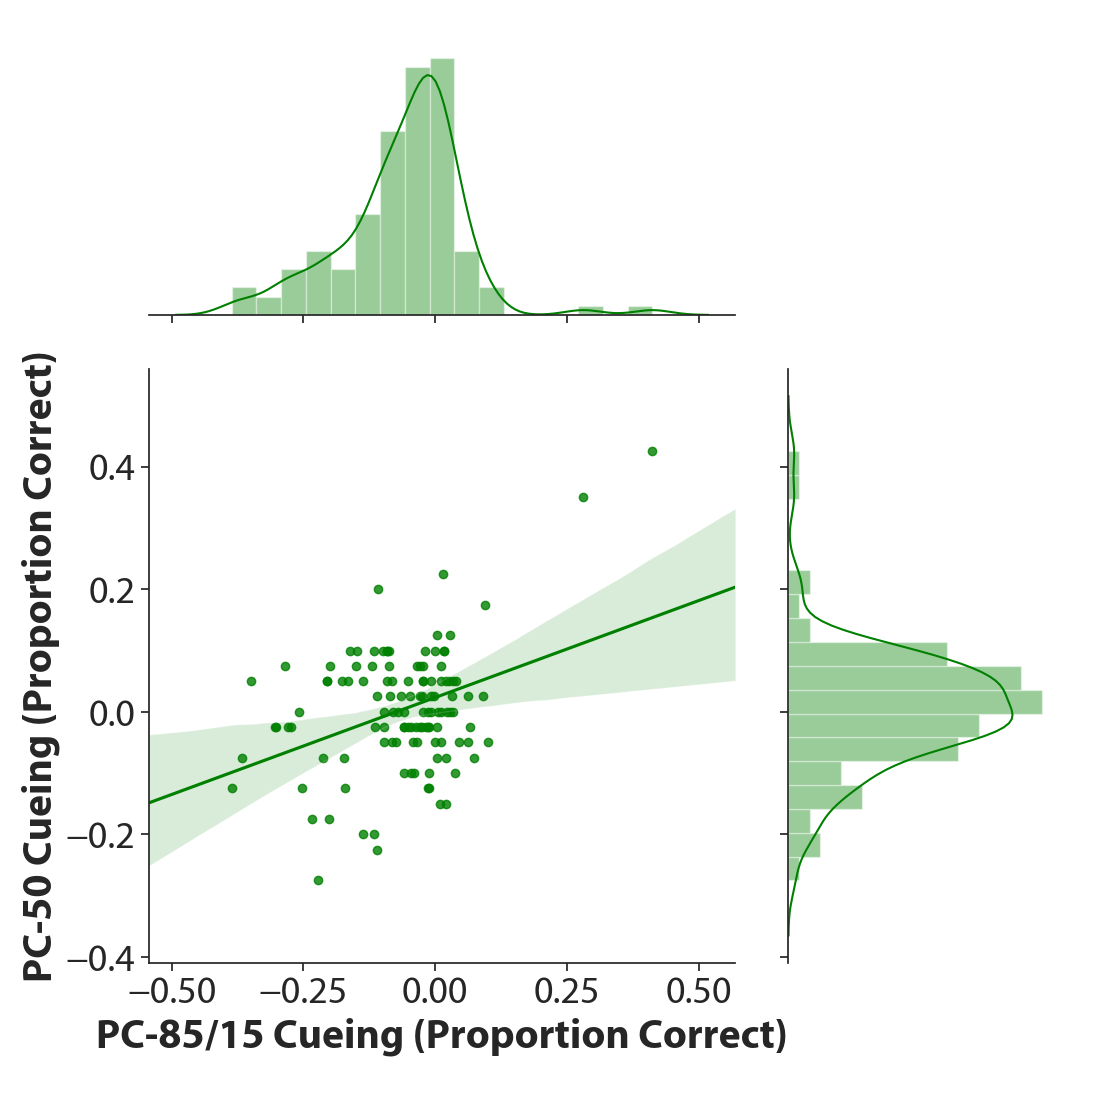

(LinregressResult(slope=0.31638416932076285, intercept=0.023299305916836904, rvalue=0.3681221320105095, pvalue=3.5250177023061936e-05, stderr=0.07356323491993665),
 LinregressResult(slope=0.3506696940963792, intercept=0.027642048687089738, rvalue=0.4059982142283625, pvalue=4.211085494368535e-06, stderr=0.07266401107103668))

In [389]:
my_corr_graphs(SC_ACC.ACC, SCT_ACC.ACC, 'PC-50 Cueing (Proportion Correct)', 'PC-85/15 Cueing (Proportion Correct)', "SC_SCT_All_ACC.png", 0, overallMainACC.Accuracy, overallACC_T.Accuracy)

So, the positive relationship from inverse efficiency seems to stem in large part from the relationship between the 2 accuracy effects. Negative means they're showing the effect we're expecting. So, the smaller the cueing effect, the smaller the LWPC effect. Let's see if this holds in a larger sample.

# Making Supplementary Tables with 95% Confidence Intervals

Now I'm making the Supplementary tables that show our data in full, with 95% CIs accompanying the means.

In [390]:
import scipy.stats

#credit for simplifying code here: https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
def mean_confidence_interval(data, acc, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    
    #adding a rounded for the sake of the table
    if acc == 0:
        mrounded = np.round(m); lowerci = np.round(m-h); upperci = np.round(m+h)
    elif acc == 1: #can't fully round proportion correct, else it goes to 1.0!
        mrounded = np.round(m,decimals=2); lowerci = np.round(m-h,decimals=2); upperci = np.round(m+h, decimals=2)
    #return m, m-h, m+h
    return mrounded, [lowerci, upperci]

In [391]:
def ci_effects(df, dv, Filter1, Filter2, Filter3, Context):
    if Context == 1:
        sub_means = df.loc[df['Task']==Filter1].loc[df['Item']==Filter2].loc[df['Feedback']==Filter3].groupby(['subject','ContextCong'])[dv].mean().reset_index()
    elif Context == 2:
        sub_means = df.loc[df['Task']==Filter1].loc[df['Item']!=Filter2].loc[df['Feedback']==Filter3].groupby(['subject','ContextCong'])[dv].mean().reset_index()
    elif Context == 3:
        sub_means = df.loc[df['Task']==Filter1].loc[df['Item']==Filter2].loc[df['Feedback']==Filter3].groupby(['subject','RunCounter','ContextCong'])[dv].mean().reset_index()
    elif Context == 4:
        sub_means = df.loc[df['Task']==Filter1].loc[df['Item']!=Filter2].loc[df['Feedback']==Filter3].groupby(['subject','RunCounter','ContextCong'])[dv].mean().reset_index()
        
    return sub_means

In [392]:
def make_ci_table(df, dv, Filter1, Filter2, Filter3, Context, Context2, RTacc, tablename):
    
    x = ci_effects(df, dv, Filter1, Filter2, Filter3, Context);
    overall_MIC_IC = mean_confidence_interval(x.loc[x['ContextCong'] == 'HighIC'][dv],RTacc)
    overall_MIC_C = mean_confidence_interval(x.loc[x['ContextCong'] == 'HighC'][dv],RTacc)
    overall_MC_IC = mean_confidence_interval(x.loc[x['ContextCong'] == 'LowIC'][dv],RTacc)
    overall_MC_C = mean_confidence_interval(x.loc[x['ContextCong'] == 'LowC'][dv],RTacc)
    
    x1 = ci_effects(df, dv, Filter1, Filter2, Filter3, Context2);
    r1_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 1][dv],RTacc)
    r1_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 1][dv],RTacc)
    r1_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 1][dv],RTacc)
    r1_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 1][dv],RTacc)

    r2_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 2][dv],RTacc)
    r2_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 2][dv],RTacc)
    r2_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 2][dv],RTacc)
    r2_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 2][dv],RTacc)

    r3_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 3][dv],RTacc)
    r3_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 3][dv],RTacc)
    r3_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 3][dv],RTacc)
    r3_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 3][dv],RTacc)
    
    r4_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 4][dv],RTacc)
    r4_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 4][dv],RTacc)
    r4_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 4][dv],RTacc)
    r4_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 4][dv],RTacc)
    
    MyTable = pd.DataFrame({'Context.TrialType': ['MC.C', 'MC.IC', 'MIC.C', 'MIC.IC'],
                     'Run 1': [r1_MC_C, r1_MC_IC, r1_MIC_C, r1_MIC_IC],
                     'Run 2': [r2_MC_C, r2_MC_IC, r2_MIC_C, r2_MIC_IC],
                     'Run 3': [r3_MC_C, r3_MC_IC, r3_MIC_C, r3_MIC_IC],
                     'Run 4': [r4_MC_C, r4_MC_IC, r4_MIC_C, r4_MIC_IC],
                     'Overall': [overall_MC_C, overall_MC_IC, overall_MIC_C, overall_MIC_IC]})

    MyTable.to_csv(csvpath+tablename)
    return MyTable

First, let's look at the No Feedback Group for the PC-85/15 items

In [393]:
make_ci_table(cdat, 'RT', 'Main', 'PC-50', 'NoFeedback', 2, 4, 0, 'NoFBSupplementaryTable1.csv')

Context.TrialType                    Run 1                    Run 2  \
0              MC.C  (634.0, [598.0, 671.0])  (627.0, [592.0, 662.0])   
1             MC.IC  (650.0, [612.0, 688.0])  (654.0, [617.0, 691.0])   
2             MIC.C  (623.0, [597.0, 649.0])  (592.0, [570.0, 613.0])   
3            MIC.IC  (632.0, [609.0, 654.0])  (599.0, [581.0, 618.0])   

                     Run 3                    Run 4                  Overall  
0  (578.0, [558.0, 599.0])  (577.0, [556.0, 597.0])  (604.0, [583.0, 625.0])  
1  (617.0, [592.0, 643.0])  (606.0, [582.0, 630.0])  (632.0, [611.0, 654.0])  
2  (616.0, [576.0, 657.0])  (610.0, [569.0, 650.0])  (610.0, [588.0, 632.0])  
3  (633.0, [595.0, 671.0])  (627.0, [589.0, 665.0])  (623.0, [602.0, 643.0])

And now what about the feedback group for the biased items via RT?

In [394]:
make_ci_table(cdat, 'RT', 'Main', 'PC-50', 'Feedback', 2, 4, 0, 'FBSupplementaryTable2.csv')

Context.TrialType                    Run 1                    Run 2  \
0              MC.C  (637.0, [615.0, 659.0])  (625.0, [601.0, 649.0])   
1             MC.IC  (662.0, [638.0, 687.0])  (645.0, [621.0, 670.0])   
2             MIC.C  (632.0, [602.0, 663.0])  (622.0, [595.0, 650.0])   
3            MIC.IC  (640.0, [613.0, 666.0])  (626.0, [601.0, 652.0])   

                     Run 3                    Run 4                  Overall  
0  (611.0, [585.0, 638.0])  (608.0, [583.0, 632.0])  (620.0, [604.0, 637.0])  
1  (636.0, [607.0, 664.0])  (624.0, [595.0, 653.0])  (642.0, [624.0, 660.0])  
2  (621.0, [592.0, 650.0])  (627.0, [600.0, 653.0])  (625.0, [607.0, 644.0])  
3  (626.0, [602.0, 650.0])  (622.0, [599.0, 644.0])  (628.0, [612.0, 645.0])

And for Accuracy, first for no feedback group, with biased items...

In [395]:
make_ci_table(adat, 'Accuracy', 'Main', 'PC-50', 'NoFeedback', 2, 4, 1, 'NoFB_ACC_SupplementaryTable3.csv')

Context.TrialType                 Run 1                 Run 2  \
0              MC.C   (0.93, [0.9, 0.97])   (0.93, [0.9, 0.97])   
1             MC.IC  (0.86, [0.81, 0.91])  (0.87, [0.81, 0.94])   
2             MIC.C   (0.93, [0.9, 0.97])  (0.96, [0.94, 0.98])   
3            MIC.IC  (0.87, [0.79, 0.95])  (0.94, [0.93, 0.96])   

                  Run 3                 Run 4               Overall  
0  (0.95, [0.93, 0.97])  (0.95, [0.93, 0.97])  (0.94, [0.93, 0.96])  
1  (0.88, [0.83, 0.94])  (0.92, [0.88, 0.96])  (0.88, [0.85, 0.92])  
2  (0.92, [0.87, 0.96])   (0.9, [0.85, 0.96])   (0.93, [0.9, 0.95])  
3   (0.93, [0.9, 0.96])   (0.9, [0.85, 0.94])  (0.91, [0.88, 0.93])

And now for the feedback group, for accuracy, for biased items...

In [396]:
make_ci_table(adat, 'Accuracy', 'Main', 'PC-50', 'Feedback', 2, 4, 1, 'FB_ACC_SupplementaryTable4.csv')

Context.TrialType                 Run 1                 Run 2  \
0              MC.C   (0.93, [0.9, 0.96])  (0.94, [0.92, 0.96])   
1             MC.IC  (0.86, [0.82, 0.91])  (0.86, [0.81, 0.91])   
2             MIC.C  (0.91, [0.86, 0.95])  (0.92, [0.89, 0.95])   
3            MIC.IC  (0.91, [0.87, 0.95])  (0.94, [0.93, 0.96])   

                  Run 3                 Run 4               Overall  
0  (0.95, [0.93, 0.96])  (0.96, [0.94, 0.97])  (0.94, [0.93, 0.95])  
1   (0.9, [0.86, 0.94])  (0.89, [0.85, 0.93])  (0.88, [0.85, 0.91])  
2  (0.91, [0.87, 0.95])  (0.91, [0.88, 0.94])  (0.91, [0.89, 0.93])  
3  (0.93, [0.91, 0.96])  (0.94, [0.92, 0.96])  (0.93, [0.91, 0.95])

#### now for unbiased items

no feedback group, unbiased, RT

In [397]:
make_ci_table(cdat, 'RT', 'Main', 'PC-50', 'NoFeedback', 1, 3, 0, 'NoFBSupplementaryTable5.csv')

Context.TrialType                    Run 1                    Run 2  \
0              MC.C  (671.0, [633.0, 709.0])  (655.0, [620.0, 691.0])   
1             MC.IC  (692.0, [654.0, 730.0])  (675.0, [640.0, 710.0])   
2             MIC.C  (655.0, [633.0, 677.0])  (637.0, [617.0, 658.0])   
3            MIC.IC  (690.0, [659.0, 721.0])  (650.0, [627.0, 672.0])   

                     Run 3                    Run 4                  Overall  
0  (637.0, [614.0, 659.0])  (622.0, [604.0, 641.0])  (646.0, [626.0, 667.0])  
1  (659.0, [635.0, 683.0])  (638.0, [614.0, 662.0])  (666.0, [645.0, 687.0])  
2  (667.0, [632.0, 703.0])  (665.0, [627.0, 703.0])  (656.0, [636.0, 676.0])  
3  (688.0, [652.0, 725.0])  (682.0, [644.0, 720.0])  (675.0, [654.0, 697.0])

feedback group, unbiased, RT:

In [398]:
make_ci_table(cdat, 'RT', 'Main', 'PC-50', 'Feedback', 1, 3, 0, 'FBSupplementaryTable6.csv')

Context.TrialType                    Run 1                    Run 2  \
0              MC.C  (671.0, [646.0, 695.0])  (659.0, [636.0, 682.0])   
1             MC.IC  (685.0, [659.0, 710.0])  (682.0, [658.0, 706.0])   
2             MIC.C  (676.0, [648.0, 704.0])  (657.0, [632.0, 681.0])   
3            MIC.IC  (686.0, [660.0, 712.0])  (667.0, [644.0, 690.0])   

                     Run 3                    Run 4                  Overall  
0  (653.0, [627.0, 679.0])  (639.0, [614.0, 665.0])  (655.0, [638.0, 672.0])  
1  (672.0, [649.0, 694.0])  (667.0, [641.0, 693.0])  (677.0, [661.0, 693.0])  
2  (672.0, [650.0, 695.0])  (657.0, [634.0, 680.0])  (665.0, [649.0, 682.0])  
3  (685.0, [659.0, 711.0])  (668.0, [644.0, 692.0])  (677.0, [660.0, 693.0])

no feedback, unbiased, accuracy:

In [399]:
make_ci_table(adat, 'Accuracy', 'Main', 'PC-50', 'NoFeedback', 1, 3, 1, 'NoFB_ACC_SupplementaryTable7.csv')

Context.TrialType                 Run 1                 Run 2  \
0              MC.C  (0.89, [0.84, 0.94])  (0.89, [0.85, 0.94])   
1             MC.IC  (0.85, [0.79, 0.92])  (0.88, [0.83, 0.93])   
2             MIC.C  (0.89, [0.85, 0.93])  (0.92, [0.89, 0.95])   
3            MIC.IC   (0.82, [0.74, 0.9])  (0.91, [0.88, 0.95])   

                  Run 3                 Run 4               Overall  
0   (0.93, [0.9, 0.96])  (0.91, [0.87, 0.95])  (0.91, [0.88, 0.93])  
1   (0.9, [0.86, 0.94])  (0.93, [0.89, 0.96])  (0.89, [0.86, 0.92])  
2  (0.89, [0.84, 0.94])  (0.85, [0.79, 0.92])  (0.89, [0.86, 0.92])  
3  (0.88, [0.83, 0.93])  (0.84, [0.77, 0.91])   (0.86, [0.83, 0.9])

feedback, unbiased, accuracy:

In [400]:
make_ci_table(adat, 'Accuracy', 'Main', 'PC-50', 'Feedback', 1, 3, 1, 'FB_ACC_SupplementaryTable8.csv')

Context.TrialType                 Run 1                 Run 2  \
0              MC.C  (0.85, [0.78, 0.91])  (0.91, [0.87, 0.94])   
1             MC.IC   (0.8, [0.74, 0.87])  (0.87, [0.82, 0.91])   
2             MIC.C  (0.89, [0.85, 0.94])  (0.92, [0.89, 0.94])   
3            MIC.IC  (0.86, [0.81, 0.91])   (0.9, [0.86, 0.93])   

                  Run 3                 Run 4               Overall  
0  (0.92, [0.89, 0.95])   (0.93, [0.9, 0.96])   (0.9, [0.88, 0.93])  
1   (0.9, [0.87, 0.93])  (0.93, [0.91, 0.95])   (0.88, [0.85, 0.9])  
2  (0.91, [0.88, 0.94])  (0.91, [0.87, 0.94])  (0.91, [0.89, 0.93])  
3  (0.88, [0.85, 0.92])  (0.89, [0.85, 0.93])   (0.88, [0.86, 0.9])

# Post-test Questionnaire Data

This was to assess participant awareness of the task manipulations.

In [401]:
%cd ..

C:\Users\cb383\Desktop\YearThree\controllearning\fbproject\LWPCfb_rep\data


In [402]:
posttest = pd.read_csv('posttest.csv')

In [403]:
#from: https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '({v:d})'.format(v=val)
    return my_autopct

In [404]:
from numpy import std, mean, sqrt

#correct if the population S.D. is expected to be equal for the two groups.
#from: https://stackoverflow.com/questions/21532471/how-to-calculate-cohens-d-in-python
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

#### We assessed explicit awareness of the underlying task structures by asking participants whether they noticed any systematic variation in the image/Stroop trial sequences at the item and block level.

In [405]:
def mypiegraph(BlockorItem, title, figname):
    fig, ax1 = plt.subplots(figsize=(8, 7));
    if BlockorItem == 0:
        Q1 = [posttest.ItemVary[posttest.ItemVary == 1].count(), posttest.ItemVary[posttest.ItemVary == 0].count()];
    elif BlockorItem == 1:
        Q1 = [posttest.BlockVary[posttest.BlockVary == 1].count(), posttest.BlockVary[posttest.BlockVary == 0].count()];
    Q1labels = ['Yes','No'];
    plt.axis('equal');
    startanglept=90;
    radiussize=0.65;
    legendfontsize=15;
    titlefontsize=17;
    
    patches, texts, junk = ax1.pie(Q1, startangle=startanglept, radius=radiussize, autopct=make_autopct(Q1));
    ax1.legend(patches, Q1labels, loc='lower center', fontsize=legendfontsize, frameon=False);
    fig.suptitle(title, fontsize=titlefontsize,fontweight="bold", y = 0.85);
    plb.savefig(figurepath+figname, bbox_inches='tight');

<IPython.core.display.Javascript object>


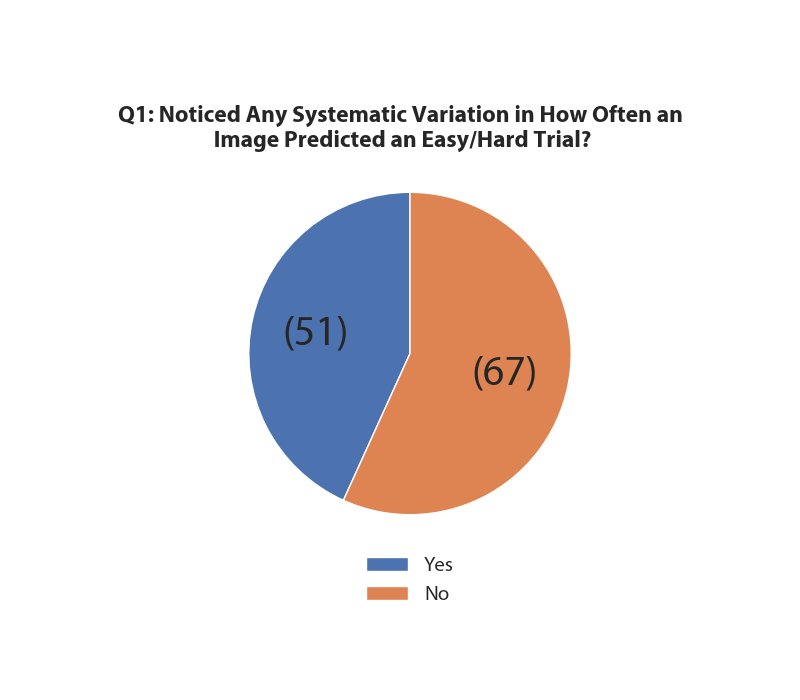

In [406]:
mypiegraph(0, 'Q1: Noticed Any Systematic Variation in How Often an\n Image Predicted an Easy/Hard Trial?', "posttestQ1_Item.png")

<IPython.core.display.Javascript object>


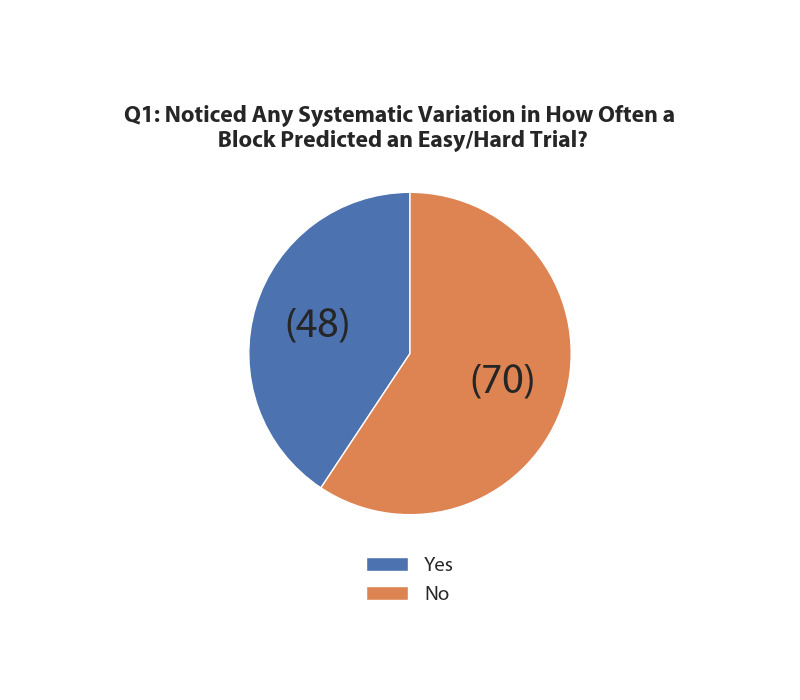

In [407]:
mypiegraph(1, 'Q1: Noticed Any Systematic Variation in How Often a\n Block Predicted an Easy/Hard Trial?', "posttestQ1_Block.png")

#### Next, we asked participants to rate how likely certain images would together predict the frequency of easy/congruent and hard/incongruent trials on a scale from 0 (never) to 100 (always). 

For instance, were the bear and bird paired together? Bear and deer? Bear and turtle?

Were any of the image category pairings rated as more predictive or nonpredictive than chance (50%)?

In [408]:
ttest = stats.ttest_1samp(posttest.FrequencyPredict_1.dropna(),50)
cohens_dz = ttest[0] / sqrt(len(posttest.FrequencyPredict_1.dropna()))
ttest, cohens_dz

(Ttest_1sampResult(statistic=-2.4866626501547784, pvalue=0.014305515940919583),
 -0.22891585190082672)

In [409]:
ttest = stats.ttest_1samp(posttest.FrequencyPredict_2.dropna(),50)
cohens_dz = ttest[0] / sqrt(len(posttest.FrequencyPredict_2.dropna()))
ttest, cohens_dz

(Ttest_1sampResult(statistic=-5.26247735287537, pvalue=6.520304690222629e-07),
 -0.48445030783218246)

In [410]:
ttest = stats.ttest_1samp(posttest.FrequencyPredict_3.dropna(),50)
cohens_dz = ttest[0] / sqrt(len(posttest.FrequencyPredict_3.dropna()))
ttest, cohens_dz

(Ttest_1sampResult(statistic=-4.144491499795415, pvalue=6.470811057461083e-05),
 -0.38153136788070136)

In [411]:
ttest = stats.ttest_1samp(posttest.FrequencyPredict_4.dropna(),50)
cohens_dz = ttest[0] / sqrt(len(posttest.FrequencyPredict_4.dropna()))
ttest, cohens_dz

(Ttest_1sampResult(statistic=-4.620443789471203, pvalue=9.918905464052934e-06),
 -0.4253463276013134)

In [412]:
ttest = stats.ttest_1samp(posttest.FrequencyPredict_5.dropna(),50)
cohens_dz = ttest[0] / sqrt(len(posttest.FrequencyPredict_5.dropna()))
ttest, cohens_dz

(Ttest_1sampResult(statistic=-4.076000311657589, pvalue=8.383924675365342e-05),
 -0.37522624294576323)

Because the image pairs were randomized across participants, we wouldn't expect these to be more predictive than chance. Another way of analyzing this would be to look at for individuals who had bear + bird paired together, did they rate that one category higher? This analysis didn't turn out in the ISPC, and this would require me to hand-code each individual participant's post-test data, so I'm going to skip for now.

In [413]:
GRP_BT = posttest.groupby(['subjID'])['FrequencyPredict_1'].mean() #1 is bear + turtle
GRP_BTSEM = pd.Series.std(GRP_BT.dropna()) / sqrt(len(GRP_BT.dropna()))
GRP_BB = posttest.groupby(['subjID'])['FrequencyPredict_2'].mean() #2 is bear + bird
GRP_BBSEM = pd.Series.std(GRP_BB.dropna()) / sqrt(len(GRP_BB.dropna()))
GRP_BD = posttest.groupby(['subjID'])['FrequencyPredict_3'].mean() #3 is bear + deer
GRP_BDSEM = pd.Series.std(GRP_BD.dropna()) / sqrt(len(GRP_BD.dropna()))
GRP_BD2 = posttest.groupby(['subjID'])['FrequencyPredict_4'].mean() #4 is bear + dog
GRP_BD2SEM = pd.Series.std(GRP_BD2.dropna()) / sqrt(len(GRP_BD2.dropna()))
GRP_BC = posttest.groupby(['subjID'])['FrequencyPredict_5'].mean() #5 is bear + cat
GRP_BCSEM = pd.Series.std(GRP_BC.dropna()) / sqrt(len(GRP_BC.dropna()))

<IPython.core.display.Javascript object>


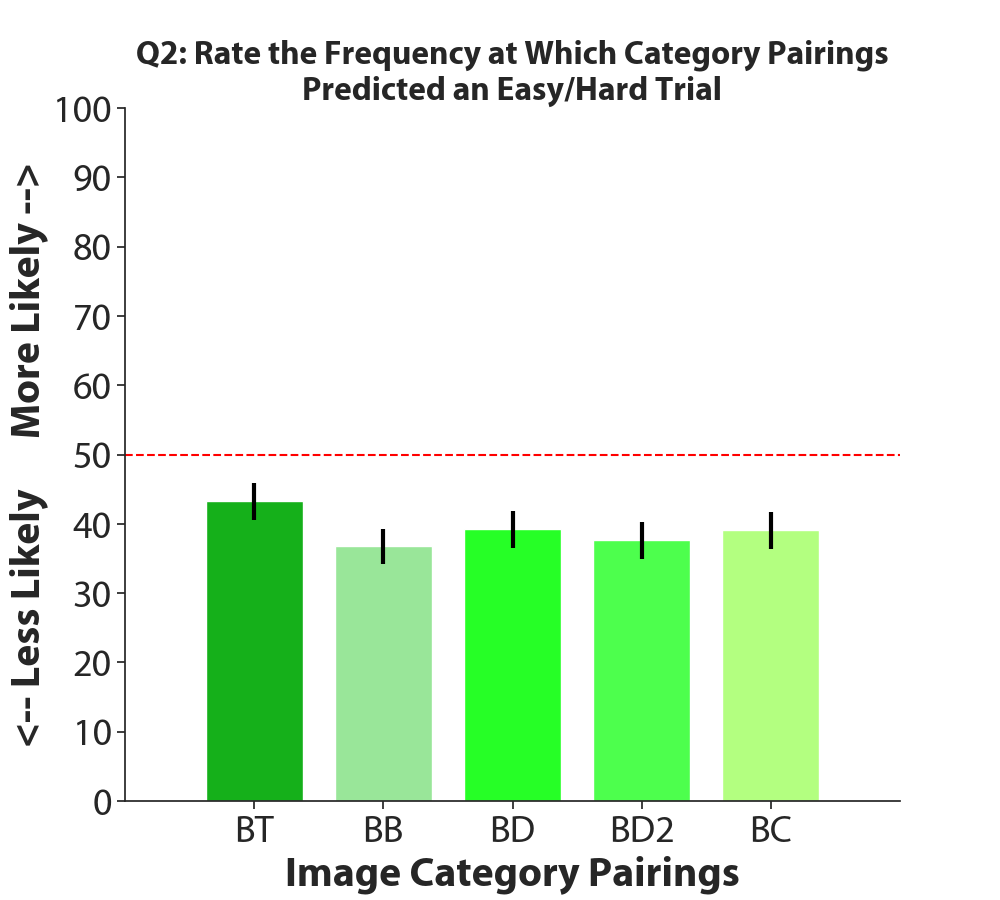

In [414]:
barwidth = 0.75; 
fig, ax = plt.subplots(figsize=(10, 9));
plt.plot([0,1,2,3,4,5,6],[50,50,50,50,50,50,50], 'r--');
rects1 = ax.bar(1,GRP_BT.dropna().mean(),barwidth,color=sns.xkcd_rgb['green'],yerr=GRP_BTSEM,ecolor='k',error_kw=dict(lw=3));
rects2 = ax.bar(2,GRP_BB.dropna().mean(),barwidth,color=(0.6,0.9,0.6),yerr=GRP_BBSEM,ecolor='k',error_kw=dict(lw=3));
rects3 = ax.bar(3,GRP_BD.dropna().mean(),barwidth,color=(0.15,1,0.15),yerr=GRP_BDSEM,ecolor='k',error_kw=dict(lw=3));
rects4 = ax.bar(4,GRP_BD2.dropna().mean(),barwidth,color=(0.3,1,0.3),yerr=GRP_BD2SEM,ecolor='k',error_kw=dict(lw=3));
rects5 = ax.bar(5,GRP_BC.dropna().mean(),barwidth,color=(0.7,1,0.5),yerr=GRP_BCSEM,ecolor='k',error_kw=dict(lw=3));
ax.set_ylim(0,100);
ax.set_xlim(0,6);
ax.set_xticklabels(('BT','BB','BD','BD2','BC'));
ax.set_xticks([1, 2, 3, 4, 5]);
ax.set_yticks(np.arange(0, 101, 10));
plt.title('Q2: Rate the Frequency at Which Category Pairings\nPredicted an Easy/Hard Trial', fontsize=24,fontweight="bold");
plt.ylabel('<-- Less Likely      More Likely -->', fontweight="bold");
plt.xlabel('Image Category Pairings',fontweight="bold");
sns.despine();

plb.savefig(figurepath+"posttestQ2.png", bbox_inches='tight');

#### Participants were then asked to match the images to the Stroop trial type that they most likely preceded. Did they perform better than chance (i.e., 2/6 cue-demand relationships correctly matched)? Unlike in the ISPC, chance here is 2/6 correct because the options were hard/incongruent, easy/congruent, and neutral; we put both the biased and unbiased items together in the SCForcedChoice question.

##### Note that we also separate out the biased images post-test question (testing against chance then as 4/3) and the unbiased images post-test question (testing against chance as 2/3).

In [415]:
ttest = stats.ttest_1samp(posttest.SCForcedChoice.dropna(),2)
cohens_dz = ttest[0] / sqrt(len(posttest.SCForcedChoice.dropna()))
ttest, cohens_dz, np.mean(posttest.SCForcedChoice.dropna()),len(posttest.SCForcedChoice.dropna())-1

(Ttest_1sampResult(statistic=3.324835299235219, pvalue=0.0011847567366641176),
 0.3073811321503907,
 2.4017094017094016,
 116)

In [416]:
ttest = stats.ttest_1samp(posttest.SCForcedChoice_bias.dropna(),(4/3))
cohens_dz = ttest[0] / sqrt(len(posttest.SCForcedChoice_bias.dropna()))
ttest, cohens_dz, np.mean(posttest.SCForcedChoice_bias.dropna()), len(posttest.SCForcedChoice_bias.dropna())-1

(Ttest_1sampResult(statistic=4.278330974850039, pvalue=3.891238574097589e-05),
 0.39553183854429874,
 1.811965811965812,
 116)

In [417]:
ttest = stats.ttest_1samp(posttest.SCForcedChoice_LWPC.dropna(),(2/3))
cohens_dz = ttest[0] / sqrt(len(posttest.SCForcedChoice_LWPC.dropna()))
ttest, cohens_dz, np.mean(posttest.SCForcedChoice_LWPC.dropna()), len(posttest.SCForcedChoice_LWPC.dropna())-1

(Ttest_1sampResult(statistic=-1.068752519287598, pvalue=0.28740019911913856),
 -0.09880620536083976,
 0.5897435897435898,
 116)

That the overall grouping is significant and the biased grouping significant, but not the unbiased, suggests that the increased PC from the biased grouping is what drives the increased recognition. This is consistent with Blais et al. (2012) suggesting that the more extreme the PC manipulation, the more explicitly aware participants are of the manipulation.

<IPython.core.display.Javascript object>


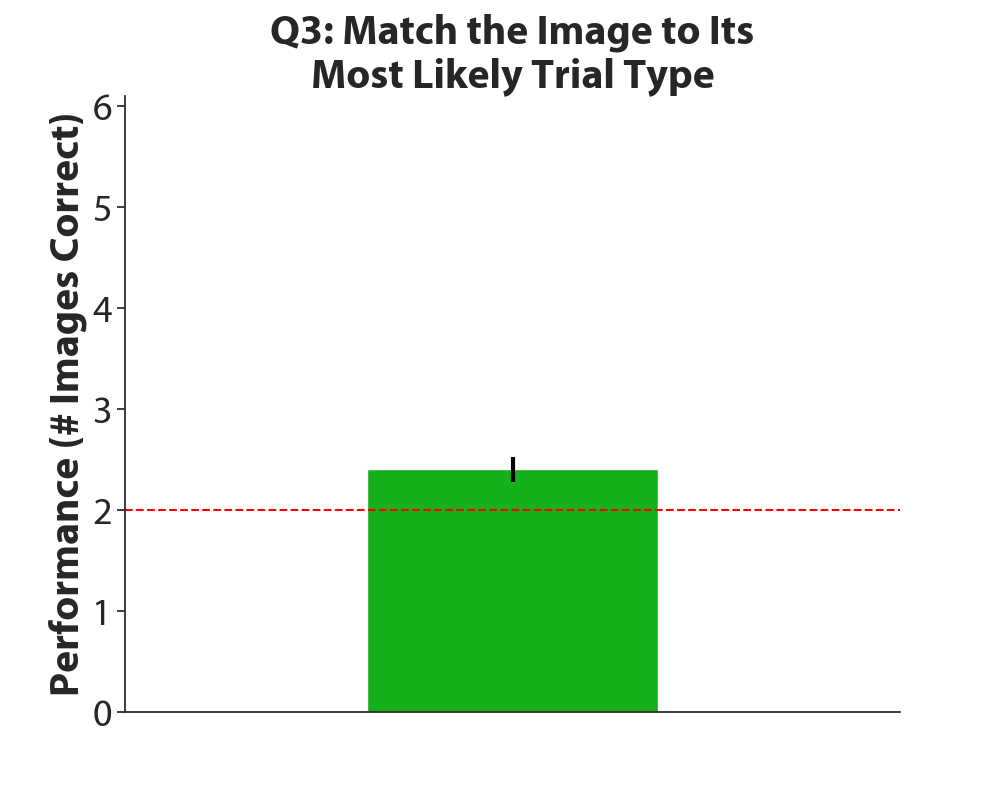

In [418]:
SCFC = posttest.groupby(['subjID'])['SCForcedChoice'].mean();
SCFCSEM = pd.Series.std(SCFC.dropna()) / sqrt(len(SCFC.dropna()));

barwidth = 0.75; 
fig, ax = plt.subplots(figsize=(10, 8));
rects1 = ax.bar(1,SCFC.dropna().mean(),barwidth,color=sns.xkcd_rgb['green'],yerr=SCFCSEM,ecolor='k',error_kw=dict(lw=3));
ax.set_ylim(0,6.1);
ax.set_xlim(0,2);
plt.plot([0,1,2],[2,2,2], 'r--');
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax.set_yticks(np.arange(0, 7, 1));
plt.title('Q3: Match the Image to Its\nMost Likely Trial Type', fontweight="bold");
plt.ylabel('Performance (# Images Correct)', fontweight="bold");
sns.despine();

plb.savefig(figurepath+"posttestQ3.png", bbox_inches='tight');

# Exploratory Analysis of the Congruency Sequence Effect

This experiment was primarily designed to look at the effects of performance feedback on the LWPC. Here, this is just me satisfying my curiosity with an exploratory analysis of the CSE.

The CSE is also theorized to be sensitive to reward (Abrahamse et al., 2016). Thus, although the trial design is limited (not all the trial types have equal percentages), we can somewhat assess the effects of FB on the CSE.

In [419]:
rdat = dat.query('(TypeOfResponse != "SCRespITI") & (RT > 200) & (RT < 1000) & (Accuracy != 0) & (StimRep != 1) & (TrialCounter != 1)').copy()
acdat = dat.query('(TrialCounter != 1)').copy()

In [420]:
dataframes = [rdat, acdat];

for df in dataframes:
    df['Feedback'] = df['Version'].isin([3,4,9,10])
    df.loc[df['Version'].isin([9,10]), 'Feedback'] = 'Feedback'
    df.loc[df['Version'].isin([3,4]), 'Feedback'] = 'NoFeedback'
    
    df['BlockOrder'] = df['Version'].isin([3,4,9,10])
    df.loc[df['Version'].isin([3,9]), 'BlockOrder'] = 'IncongFirst'
    df.loc[df['Version'].isin([4,10]), 'BlockOrder'] = 'CongFirst'
    
    df['Task'] = df['RunCounter'].isin([4])
    df.loc[df['RunCounter'].isin([0]), 'Task'] = 'Practice'
    df.loc[df['RunCounter'].isin([1,2,3,4]), 'Task'] = 'Main'
    
    df['BlockType'] = df['ContextType'].isin([0])
    df.loc[df['ContextType'].isin([1]), 'BlockType'] = 'MIC/High'
    df.loc[df['ContextType'].isin([0]), 'BlockType'] = 'MC/Low'
    
    df['Item'] = df['ItemType'].isin([1])
    df.loc[df['ItemType'].isin([1]),'Item'] = 'PC-85'
    df.loc[df['ItemType'].isin([2]),'Item'] = 'PC-15'
    df.loc[df['ItemType'].isin([3]),'Item'] = 'PC-50'

    df['Congruency'] = df['TrialType'].isin([1])
    df.loc[df['TrialType'].isin([0]),'Congruency'] = 'Incongruent'
    df.loc[df['TrialType'].isin([1]),'Congruency'] = 'Congruent'
    
    df['PrevCong'] = df['Prevtrial'].isin([1])
    df.loc[df['Prevtrial'].isin([1]),'PrevCong'] = 'Incongruent'
    df.loc[~df['Prevtrial'].isin([1]),'PrevCong'] = 'Congruent'
    
    df['CSE'] = df['Sequential'].isin([1])
    df.loc[df['Sequential'].isin([1]),'CSE'] = 'Cong-Cong'
    df.loc[df['Sequential'].isin([2]),'CSE'] = 'Incong-Cong'
    df.loc[df['Sequential'].isin([3]),'CSE'] = 'Cong-Incong'
    df.loc[df['Sequential'].isin([4]),'CSE'] = 'Incong-Incong'

Let's take a peak at the means...

In [421]:
mean_cueing_effect(rdat, 'RT', 'Main', 'PC-50', 'NoFeedback', 4) #pc-85/15 items

(CSE
 Cong-Cong        602.386033
 Cong-Incong      626.344924
 Incong-Cong      607.870895
 Incong-Incong    621.474279
 Name: RT, dtype: float64, CSE
 Cong-Cong        5.286459
 Cong-Incong      5.201513
 Incong-Cong      5.185230
 Incong-Incong    5.152311
 Name: RT, dtype: float64)

In [422]:
mean_cueing_effect(rdat, 'RT', 'Main', 'PC-50', 'NoFeedback', 3) #pc-50/50 items

(CSE
 Cong-Cong        650.131611
 Cong-Incong      663.120529
 Incong-Cong      651.060017
 Incong-Incong    678.630526
 Name: RT, dtype: float64, CSE
 Cong-Cong        5.290343
 Cong-Incong      5.225806
 Incong-Cong      4.904853
 Incong-Incong    5.246757
 Name: RT, dtype: float64)

In [423]:
mean_cueing_effect(rdat, 'RT', 'Main', 'PC-50', 'Feedback', 4) #pc-85/15 items

(CSE
 Cong-Cong        619.953856
 Cong-Incong      632.222164
 Incong-Cong      621.549849
 Incong-Incong    627.790035
 Name: RT, dtype: float64, CSE
 Cong-Cong        4.223507
 Cong-Incong      4.106416
 Incong-Cong      4.156639
 Incong-Incong    4.160985
 Name: RT, dtype: float64)

In [424]:
mean_cueing_effect(rdat, 'RT', 'Main', 'PC-50', 'Feedback', 3) #pc-50/50 items

(CSE
 Cong-Cong        660.693162
 Cong-Incong      675.340910
 Incong-Cong      659.616294
 Incong-Incong    676.795872
 Name: RT, dtype: float64, CSE
 Cong-Cong        4.161708
 Cong-Incong      4.040551
 Incong-Cong      4.036308
 Incong-Incong    3.994084
 Name: RT, dtype: float64)

In [425]:
mean_cueing_effect(acdat, 'Accuracy', 'Main', 'PC-50', 'NoFeedback', 4) #pc-85/15 items

(CSE
 Cong-Cong        0.940822
 Cong-Incong      0.893369
 Incong-Cong      0.938365
 Incong-Incong    0.914443
 Name: Accuracy, dtype: float64, CSE
 Cong-Cong        0.003995
 Cong-Incong      0.005819
 Incong-Cong      0.003777
 Incong-Incong    0.005916
 Name: Accuracy, dtype: float64)

In [426]:
mean_cueing_effect(acdat, 'Accuracy', 'Main', 'PC-50', 'NoFeedback', 3) #pc-50/50 items

(CSE
 Cong-Cong        0.902974
 Cong-Incong      0.885944
 Incong-Cong      0.893636
 Incong-Incong    0.867262
 Name: Accuracy, dtype: float64, CSE
 Cong-Cong        0.006430
 Cong-Incong      0.006834
 Incong-Cong      0.006793
 Incong-Incong    0.008492
 Name: Accuracy, dtype: float64)

In [427]:
mean_cueing_effect(acdat, 'Accuracy', 'Main', 'PC-50', 'Feedback', 4) #pc-85/15 items

(CSE
 Cong-Cong        0.941777
 Cong-Incong      0.908241
 Incong-Cong      0.937521
 Incong-Incong    0.932700
 Name: Accuracy, dtype: float64, CSE
 Cong-Cong        0.002826
 Cong-Incong      0.005037
 Incong-Cong      0.003166
 Incong-Incong    0.003732
 Name: Accuracy, dtype: float64)

In [428]:
mean_cueing_effect(acdat, 'Accuracy', 'Main', 'PC-50', 'Feedback', 3) #pc-50/50 items

(CSE
 Cong-Cong        0.904126
 Cong-Incong      0.871112
 Incong-Cong      0.906770
 Incong-Incong    0.888470
 Name: Accuracy, dtype: float64, CSE
 Cong-Cong        0.005723
 Cong-Incong      0.006088
 Incong-Cong      0.004672
 Incong-Incong    0.005618
 Name: Accuracy, dtype: float64)

OK, let's actually analyze the data... Note that there aren't enough trials to analyze PC-50 items. I am also leaving off Block Order because this is just exploratory anyway.

In [429]:
%cd csvdata

C:\Users\cb383\Desktop\YearThree\controllearning\fbproject\LWPCfb_rep\data\csvdata


In [430]:
CSE_RT = rdat.loc[rdat['Task'] == 'Main'].loc[rdat['Item'] != 'PC-50'].groupby(['subject','Feedback','PrevCong','Congruency'])['RT'].mean().reset_index();
CSE_ACC = acdat.loc[acdat['Task'] == 'Main'].loc[adat['Item'] != 'PC-50'].groupby(['subject','Feedback','PrevCong','Congruency'])['Accuracy'].mean().reset_index();

CSE_RT_T = rdat.loc[rdat['Task'] == 'Main'].loc[rdat['Item'] == 'PC-50'].groupby(['subject','Feedback','PrevCong','Congruency'])['RT'].mean().reset_index();
CSE_ACC_T = acdat.loc[acdat['Task'] == 'Main'].loc[acdat['Item'] == 'PC-50'].groupby(['subject','Feedback','PrevCong','Congruency'])['Accuracy'].mean().reset_index();

#create tidy data csvs
CSE_RT.to_csv(csvpath+'CSE_ANOVA_RT.csv')
CSE_ACC.to_csv(csvpath+'CSE_ANOVA_ACC.csv')
CSE_RT_T.to_csv(csvpath+'CSE_ANOVA_RT_T.csv')
CSE_ACC_T.to_csv(csvpath+'CSE_ANOVA_ACC_T.csv')

In [431]:
%%writefile CSEAnova.R

install.packages("psych",repos='https://mirrors.nics.utk.edu/cran/')
install.packages("ez",repos='https://mirrors.nics.utk.edu/cran/')
library(psych)
library(ez)

CSE_RT <- read.csv('CSE_ANOVA_RT.csv')

CSE_RT$subject = as.factor(CSE_RT$subject)
CSE_RT$Feedback = as.factor(CSE_RT$Feedback)
CSE_RT$PrevCong = as.factor(CSE_RT$PrevCong)
CSE_RT$Congruency = as.factor(CSE_RT$Congruency)

CSERT_AN <- ezANOVA(data=as.data.frame(CSE_RT),
                                  dv=.(RT),
                                  wid=.(subject),
                                  within=.(PrevCong, Congruency),
                                  between=.(Feedback),
                                  detailed=TRUE)
print(CSERT_AN)

#

CSE_ACC <- read.csv('CSE_ANOVA_ACC.csv')

CSE_ACC$subject = as.factor(CSE_ACC$subject)
CSE_ACC$Feedback = as.factor(CSE_ACC$Feedback)
CSE_ACC$PrevCong = as.factor(CSE_ACC$PrevCong)
CSE_ACC$Congruency = as.factor(CSE_ACC$Congruency)

CSEACC_AN <- ezANOVA(data=as.data.frame(CSE_ACC),
                                  dv=.(Accuracy),
                                  wid=.(subject),
                                  within=.(PrevCong, Congruency),
                                  between=.(Feedback),
                                  detailed=TRUE)
print(CSEACC_AN)

Overwriting CSEAnova.R


In [432]:
! Rscript CSEAnova.R

package 'psych' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cb383\AppData\Local\Temp\Rtmpu0Xapd\downloaded_packages
package 'ez' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cb383\AppData\Local\Temp\Rtmpu0Xapd\downloaded_packages
$ANOVA
                        Effect DFn DFd          SSn        SSd            F
1                  (Intercept)   1 118 1.844816e+08 2388897.26 9112.5034395
2                     Feedback   1 118 1.415260e+04 2388897.26    0.6990704
3                     PrevCong   1 118 3.702692e+01   25022.92    0.1746069
5                   Congruency   1 118 2.357948e+04   75716.86   36.7471524
4            Feedback:PrevCong   1 118 8.928700e+01   25022.92    0.4210485
6          Feedback:Congruency   1 118 2.722849e+03   75716.86    4.2433910
7          PrevCong:Congruency   1 118 2.013175e+03   26983.00    8.8038607
8 Feedback:PrevCong:Congruency   1 118 1.404469e+02   26983.

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/psych_1.8.12.zip'
Content type 'application/zip' length 5908111 bytes (5.6 MB)
downloaded 5.6 MB

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/ez_4.4-0.zip'
Content type 'application/zip' length 332373 bytes (324 KB)
downloaded 324 KB

Warning message:
package 'psych' was built under R version 3.4.4 
Warning message:
package 'ez' was built under R version 3.4.4 


Let's look at the graphs...

<IPython.core.display.Javascript object>


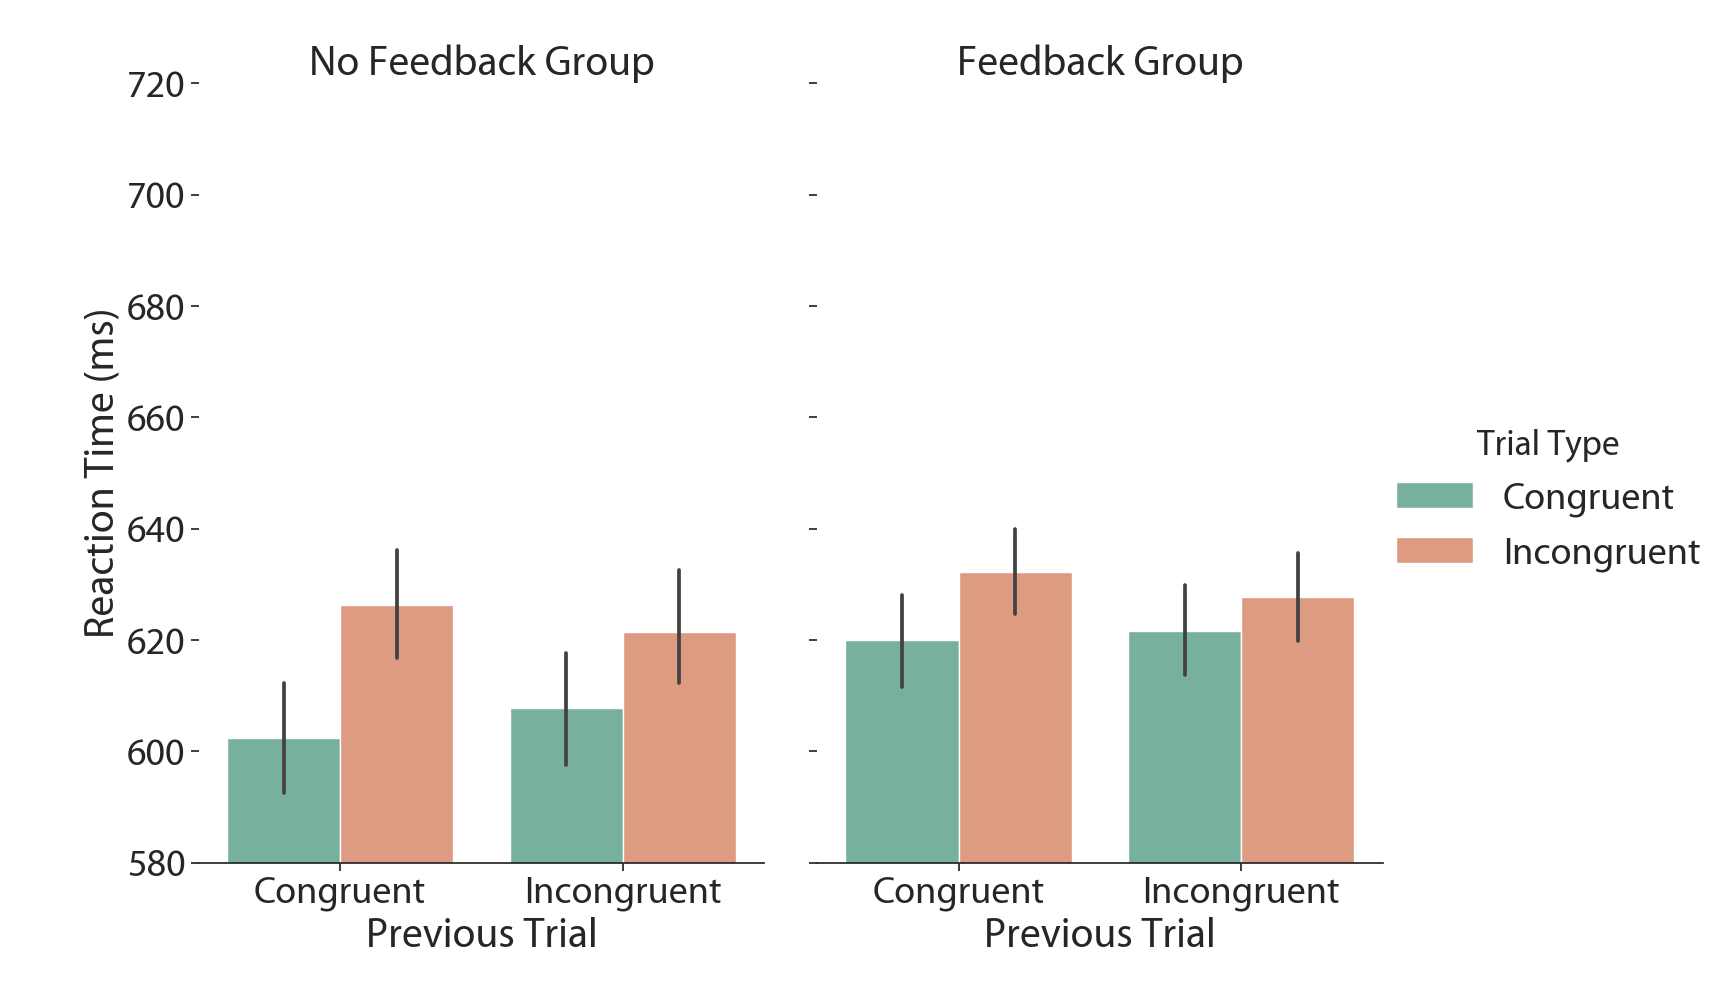

In [433]:
mybargraph("PrevCong","RT","Congruency","Feedback",["Congruent", "Incongruent"],CSE_RT,"Previous Trial","Reaction Time (ms)","Congruency Sequence Effect (PC-85/15) for FB Grps","Trial Type",580,720,"CSE_RT.png", 20)

<IPython.core.display.Javascript object>


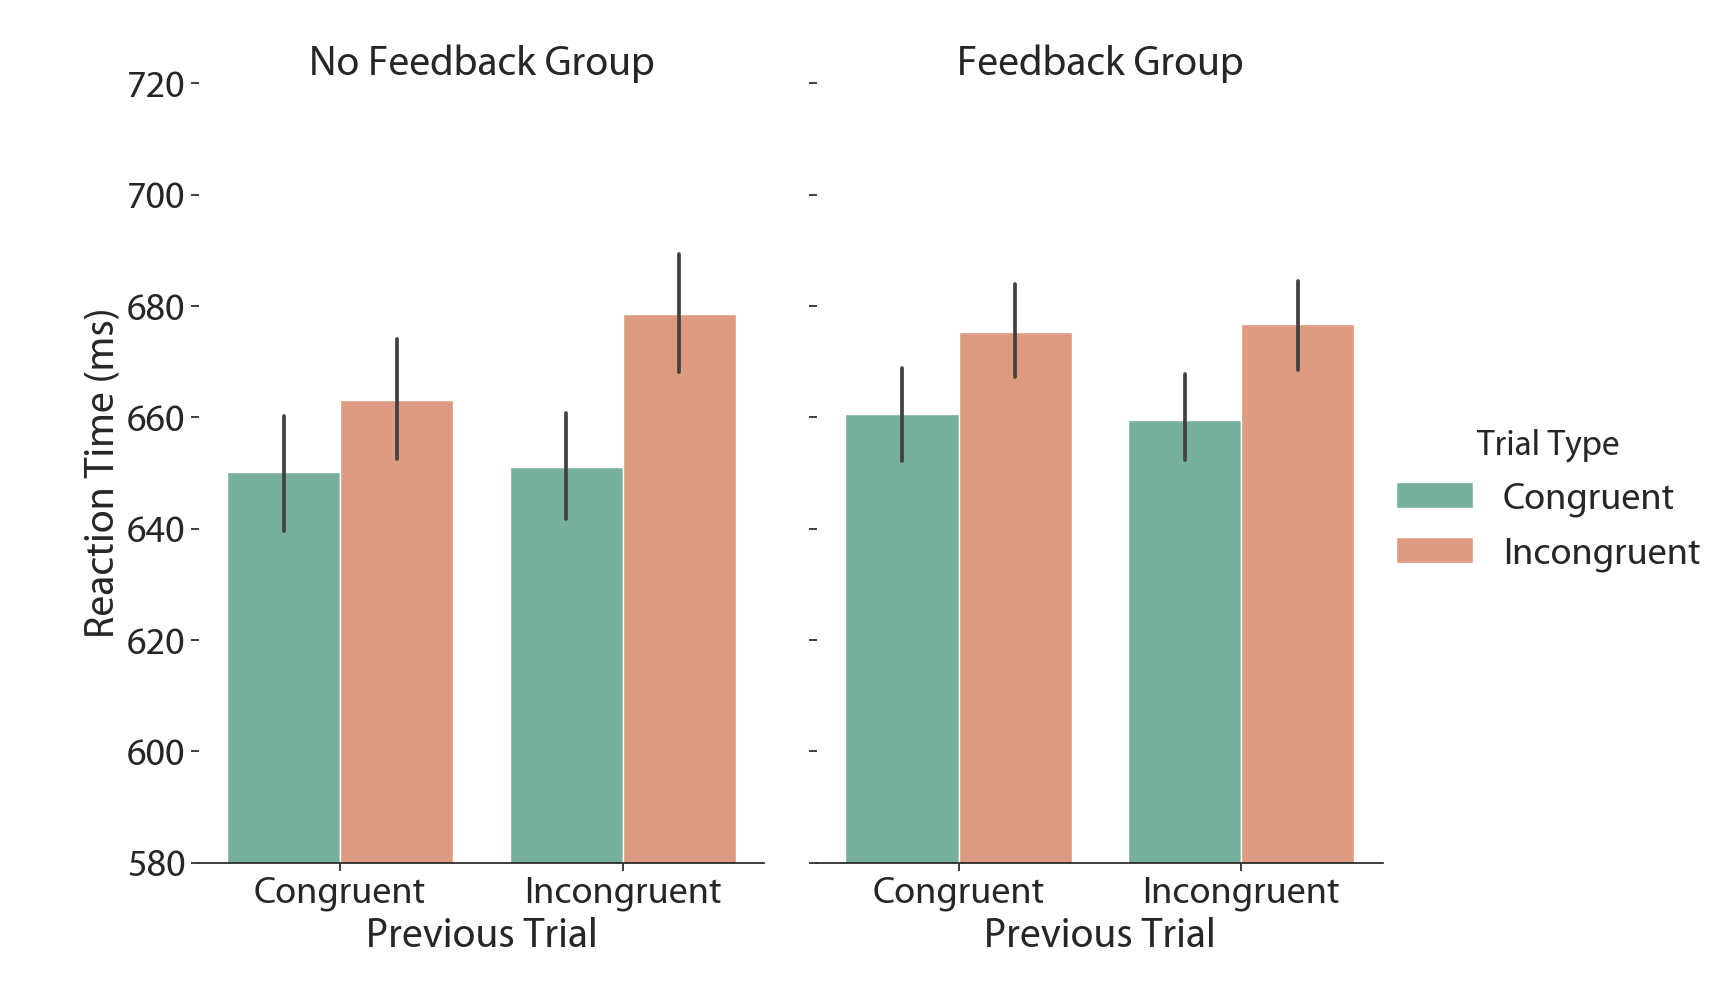

In [434]:
mybargraph("PrevCong","RT","Congruency","Feedback",["Congruent", "Incongruent"],CSE_RT_T,"Previous Trial","Reaction Time (ms)","Congruency Sequence Effect (PC-50) for FB Grps","Trial Type",580,720,"CSE_RT_T.png",20)

<IPython.core.display.Javascript object>


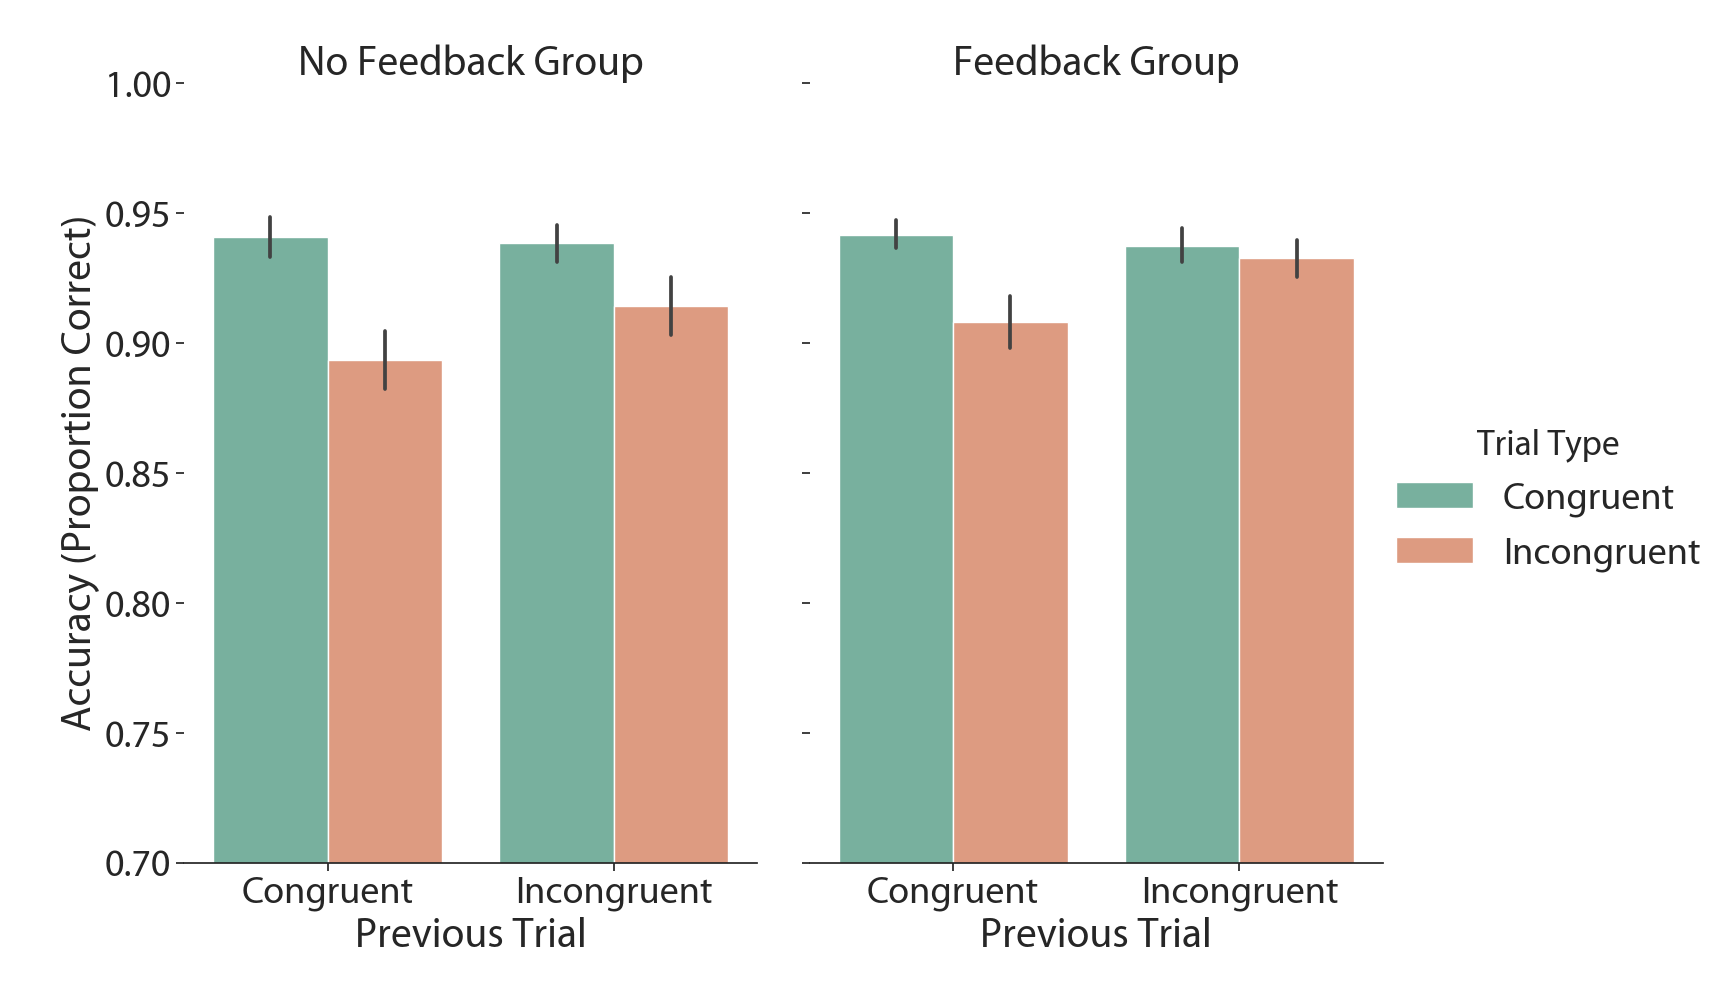

In [435]:
mybargraph("PrevCong","Accuracy","Congruency","Feedback",["Congruent", "Incongruent"],CSE_ACC,"Previous Trial","Accuracy (Proportion Correct)","Congruency Sequence Effect (PC-85/15) for FB Grps","Trial Type",0.7,1.0,"CSE_ACC.png",0.05)

<IPython.core.display.Javascript object>


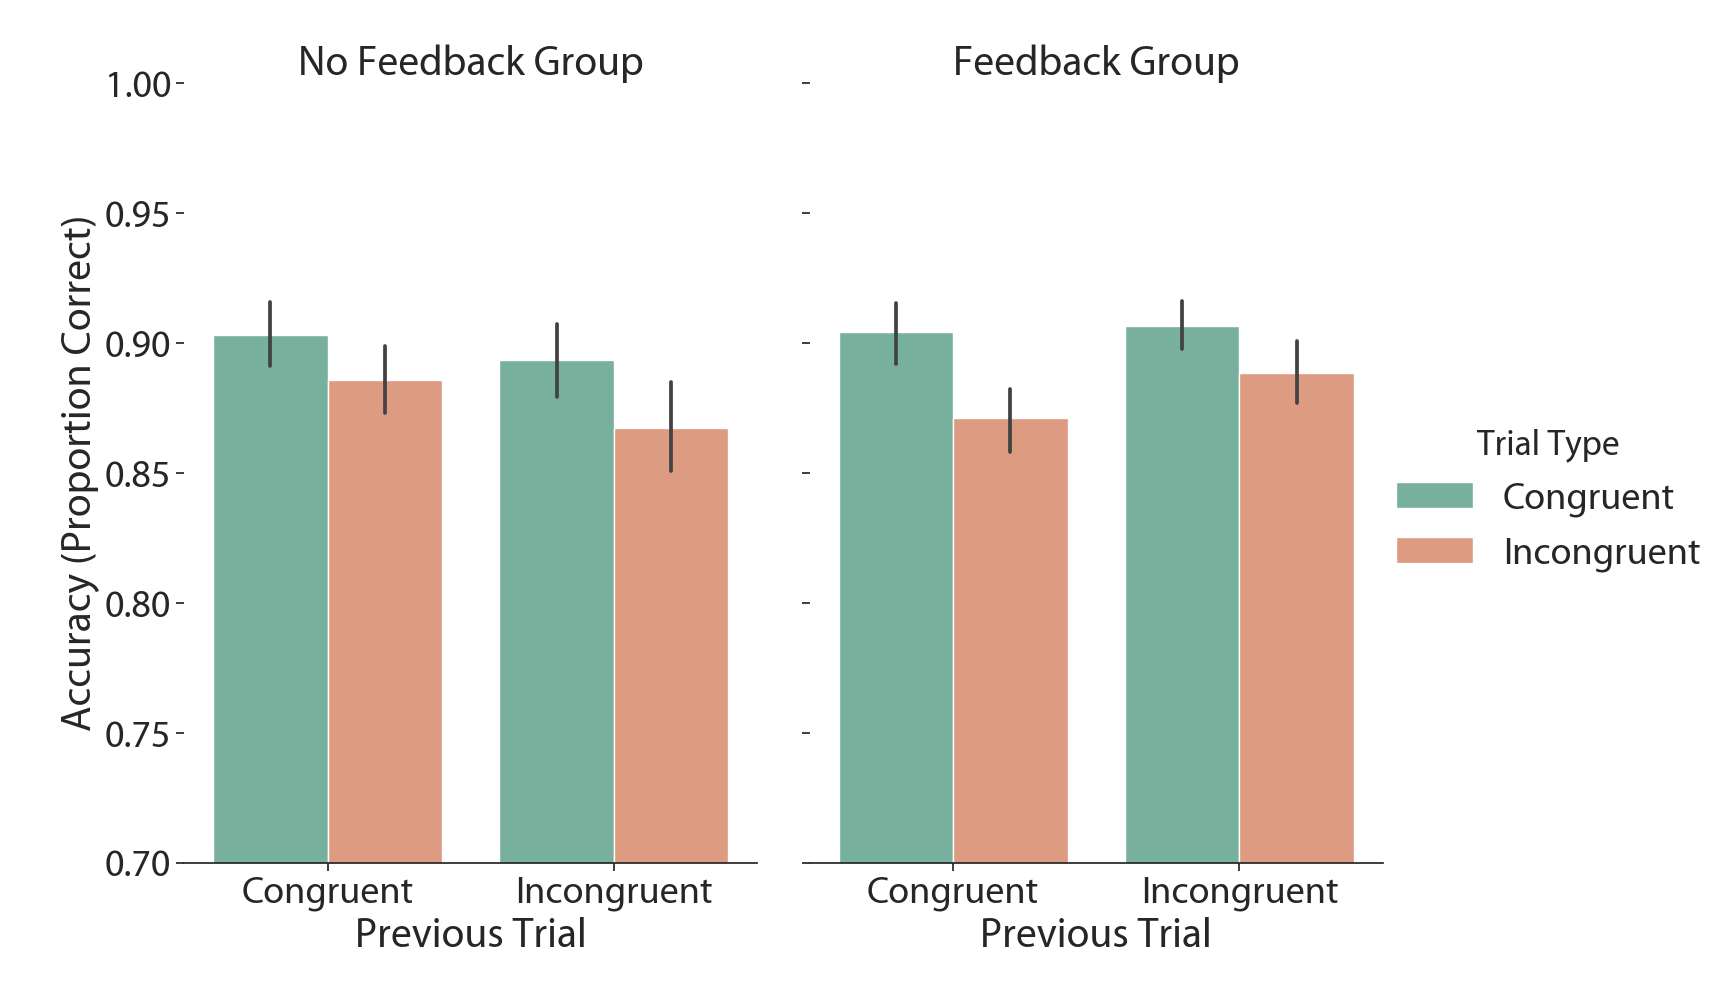

In [436]:
mybargraph("PrevCong","Accuracy","Congruency","Feedback",["Congruent", "Incongruent"],CSE_ACC_T,"Previous Trial","Accuracy (Proportion Correct)","Congruency Sequence Effect (PC-50) for FB Grps","Trial Type",0.7,1.0,"CSE_ACC_T.png",0.05)